In [2]:
from pathlib import Path
import re

import scope
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import numpy as np

sns.set_theme(style="whitegrid", font_scale=1.5, palette="Set2")
plt.rcParams['figure.dpi'] = 300

In [3]:
_STEP_REGEX   = re.compile(r"\b(step|timestep|steps|total_steps|global_step)\b", re.I)

def _read_log(path: Path) -> pd.DataFrame:
    """Load *path* and return a DataFrame with columns [step, reward]."""
    df = pd.read_json(path, lines=True)

    # Auto-detect columns if none supplied
    step_col = next((c for c in df.columns if _STEP_REGEX.search(c)), None)
    val_col = 'episode/score'

    return df[[step_col, val_col]].rename(columns={step_col: "step", val_col: "reward"})

def smooth_interp(df: pd.DataFrame, step_interval=10, window=1000) -> np.ndarray:
    """Interpolate the DataFrame to a common step interval and apply a rolling mean."""
    max_step = df['step'].max()
    common_steps = np.arange(0, max_step + step_interval, step_interval)

    interp = np.interp(common_steps, df['step'], df['reward'])
    windowed = pd.Series(interp).rolling(window=window, center=True, min_periods=1).mean().to_numpy()

    return windowed

def breach_threshold(fn: str, target_value: float, step_interval=10, window_size=1000) -> int:
    df = _read_log(fn)
    window = smooth_interp(df, step_interval, window_size)

    first_index = np.argmax(window >= target_value)
    return (first_index if first_index > 0 else len(window)) * step_interval

def find_max(fn: str, step_interval=10, window_size=1000) -> int:
    df = _read_log(fn)
    window = smooth_interp(df, step_interval, window_size)

    l=len(window)
    return window.max()

def find_files_with_keyword(root_dir, filename, keyword):
    candidate_files =  [str(p) for p in Path(root_dir).rglob('*') if filename in str(p)]
    return sorted([str(p) for p in candidate_files if keyword in str(p)])

In [10]:
res = {}
all_steps = []
step_interval = 10
window_size = 2000
threshold = 0.9
for f in find_files_with_keyword('logdir/PICK_YCB', 'scores.jsonl', 'train'):
    train_name = f.split('/')[3]

    found = False
    for k in res.keys():
        if k in train_name:
            found = True
            break
    
    max_ret = find_max(f, step_interval, window_size)
    step = breach_threshold(f, max_ret * threshold, step_interval, window_size)
    all_steps.append(step)

    windowed = smooth_interp(_read_log(f), step_interval, window_size)
    normalised = (windowed - windowed[0]) / (max_ret * threshold - windowed[0] + 1e-8)
    if not found:
        res[train_name] = [normalised]
    else:
        res[k].append(normalised)

T_idx = int(np.percentile(all_steps, 75, axis=0)) // step_interval
res = {k: [v[:T_idx+1] for v in vs] for k, vs in res.items()}
print(f"75th percentile of steps to reach {threshold*100}% of max return: {T_idx}")
print({k: [len(v) for v in vs] for k, vs in res.items()})

def functional_permutation_test(name1, name2, n_permutations=10000, random_seed=42):
    curve1 = np.array(res[name1])
    curve2 = np.array(res[name2])
    pts_trunc = np.arange(0, T_idx*step_interval + 1, step_interval)
    m = curve2.shape[0]

    mean_diff = curve1.mean(axis=0) - curve2.mean(axis=0)
    T_obs = np.trapz(mean_diff, x=pts_trunc)
    # 5. build null distribution by permutation
    rng = np.random.default_rng(random_seed)
    pooled = np.vstack([curve1, curve2])
    labels = np.array([0]*m + [1]*m)
    count = 0
    for _ in range(n_permutations):
        rng.shuffle(labels)
        A_idx = labels == 0
        B_idx = labels == 1
        T_star = np.trapz(np.mean(pooled[A_idx], axis=0)
                         - np.mean(pooled[B_idx], axis=0),
                          x=pts_trunc)
        if abs(T_star) >= abs(T_obs):
            count += 1
    p_value = (count + 1) / (n_permutations + 1)  # add‑1 correction
    return {
        'T_obs': T_obs,
        'p_value': p_value,
    }

for modelA, modelB in itertools.combinations(res.keys(), 2):
    print(modelA, modelB)
    print(functional_permutation_test(modelA, modelB, n_permutations=10000, random_seed=42))

75th percentile of steps to reach 90.0% of max return: 69033
{'baseline_pick_ycb_train_ID': [69034, 69034, 69034], 'CLIPFT_pick_ycb_train_ID': [69034, 69034, 69034], 'CLIPFreeze_pick_ycb_train_ID': [69034, 69034, 69034], 'CLIPPartial_pick_ycb_train_ID': [69034, 69034, 69034], 'DINOFT_pick_ycb_train_ID': [69034, 69034, 69034], 'DINOFreeze_pick_ycb_train_ID': [69034, 69034, 69034], 'DINOPartial_pick_ycb_train_ID': [69034, 69034, 69034]}
baseline_pick_ycb_train_ID CLIPFT_pick_ycb_train_ID
{'T_obs': 3084.324651943806, 'p_value': 1.0}
baseline_pick_ycb_train_ID CLIPFreeze_pick_ycb_train_ID
{'T_obs': 8030.330517168328, 'p_value': 0.7965203479652034}
baseline_pick_ycb_train_ID CLIPPartial_pick_ycb_train_ID
{'T_obs': 17226.9484253209, 'p_value': 0.698930106989301}
baseline_pick_ycb_train_ID DINOFT_pick_ycb_train_ID
{'T_obs': 5606.270016549712, 'p_value': 0.7946205379462054}
baseline_pick_ycb_train_ID DINOFreeze_pick_ycb_train_ID
{'T_obs': -1852.2294067003577, 'p_value': 1.0}
baseline_pick_ycb_

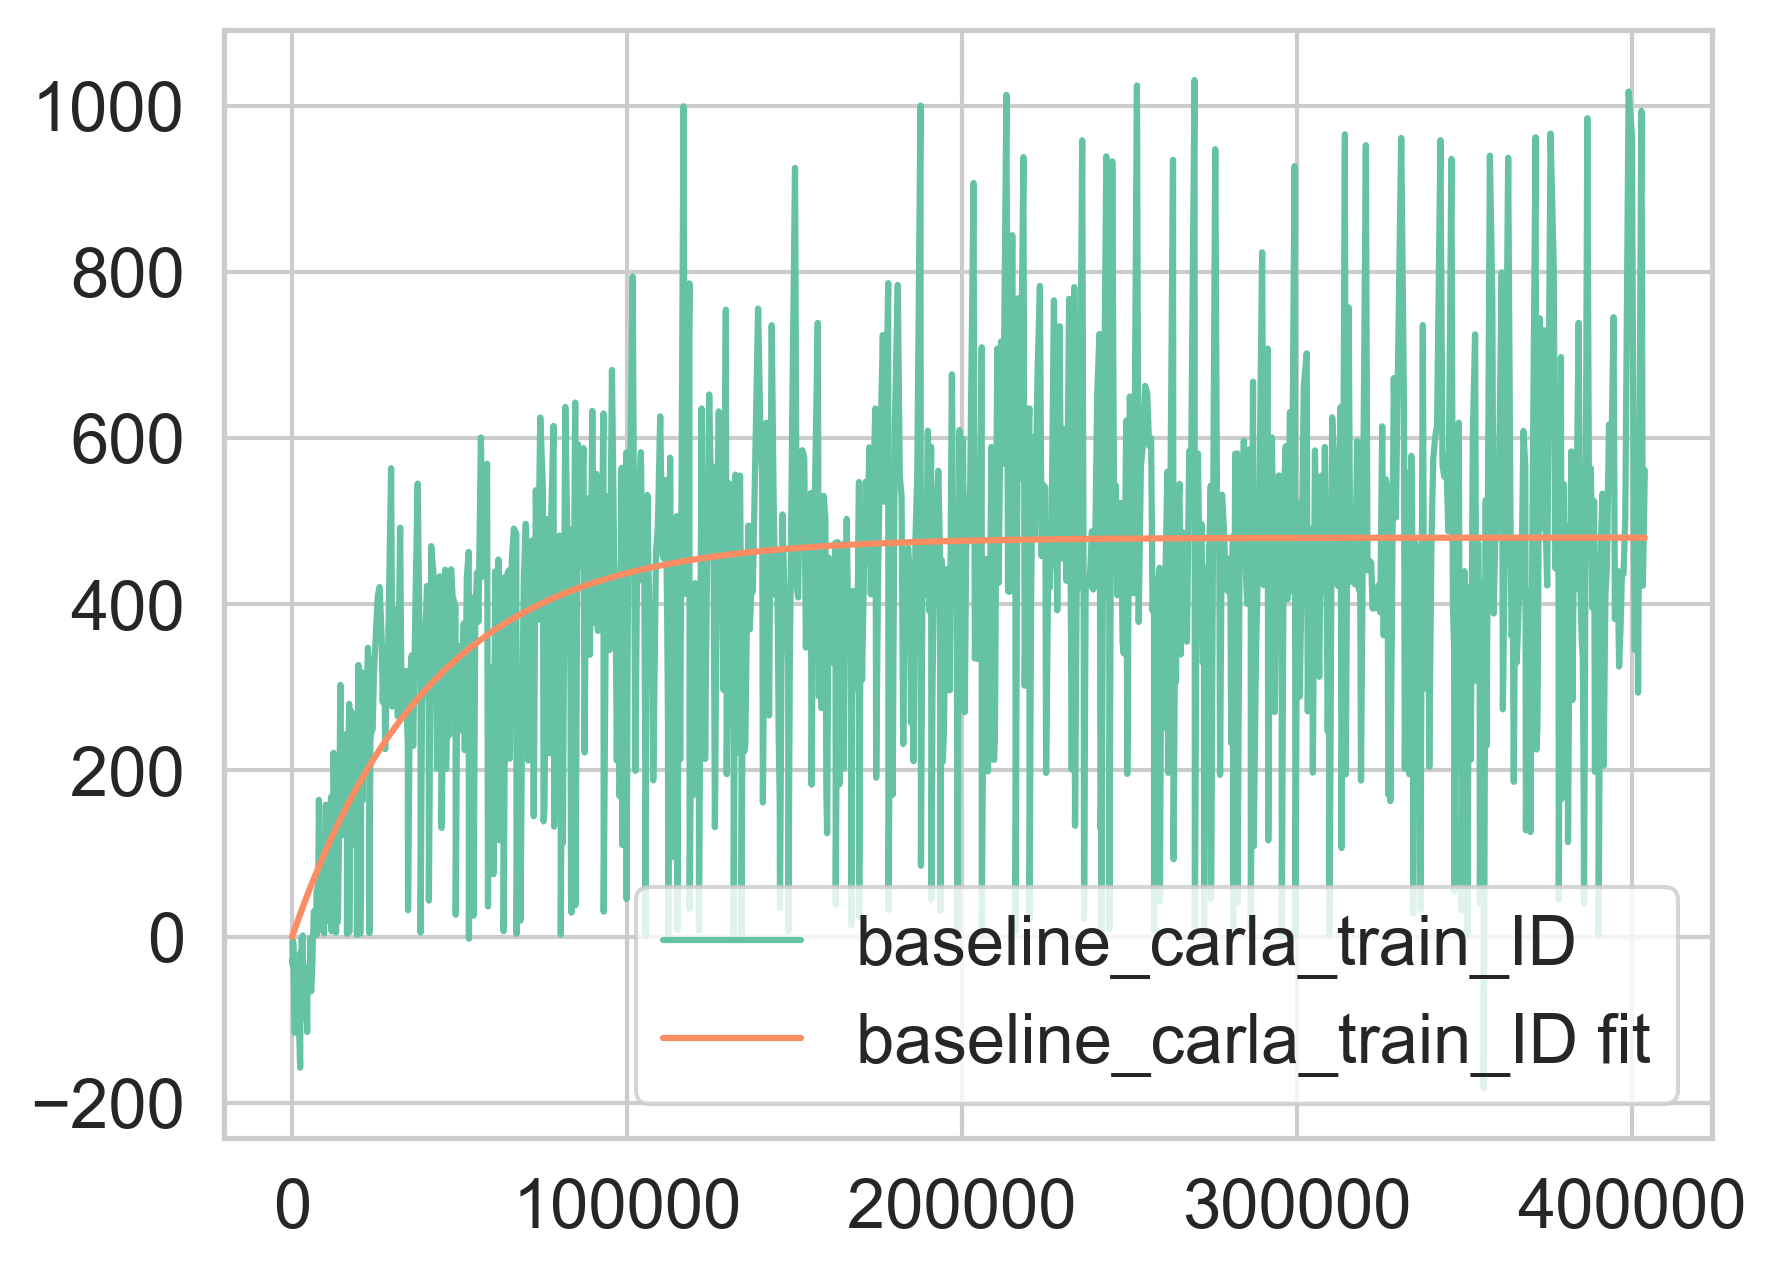

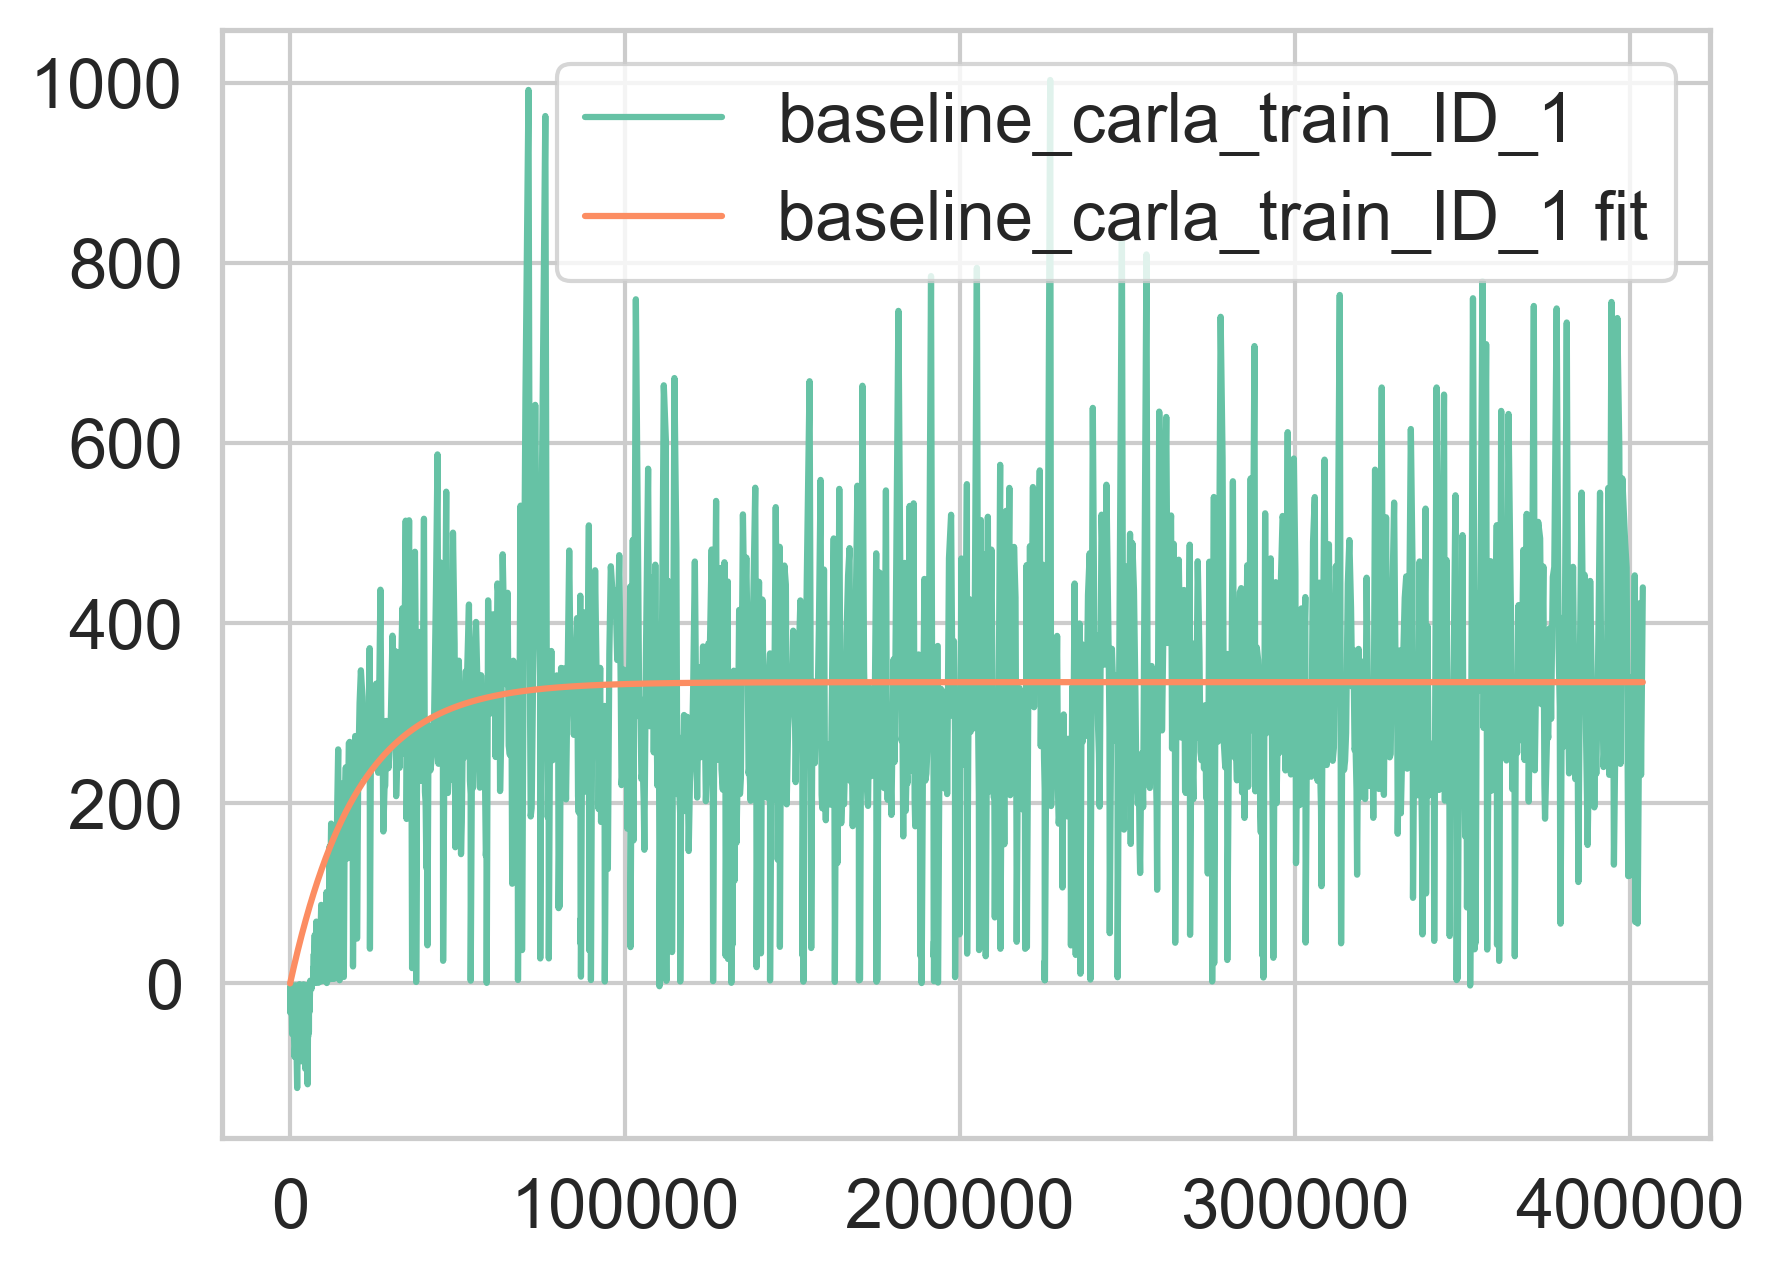

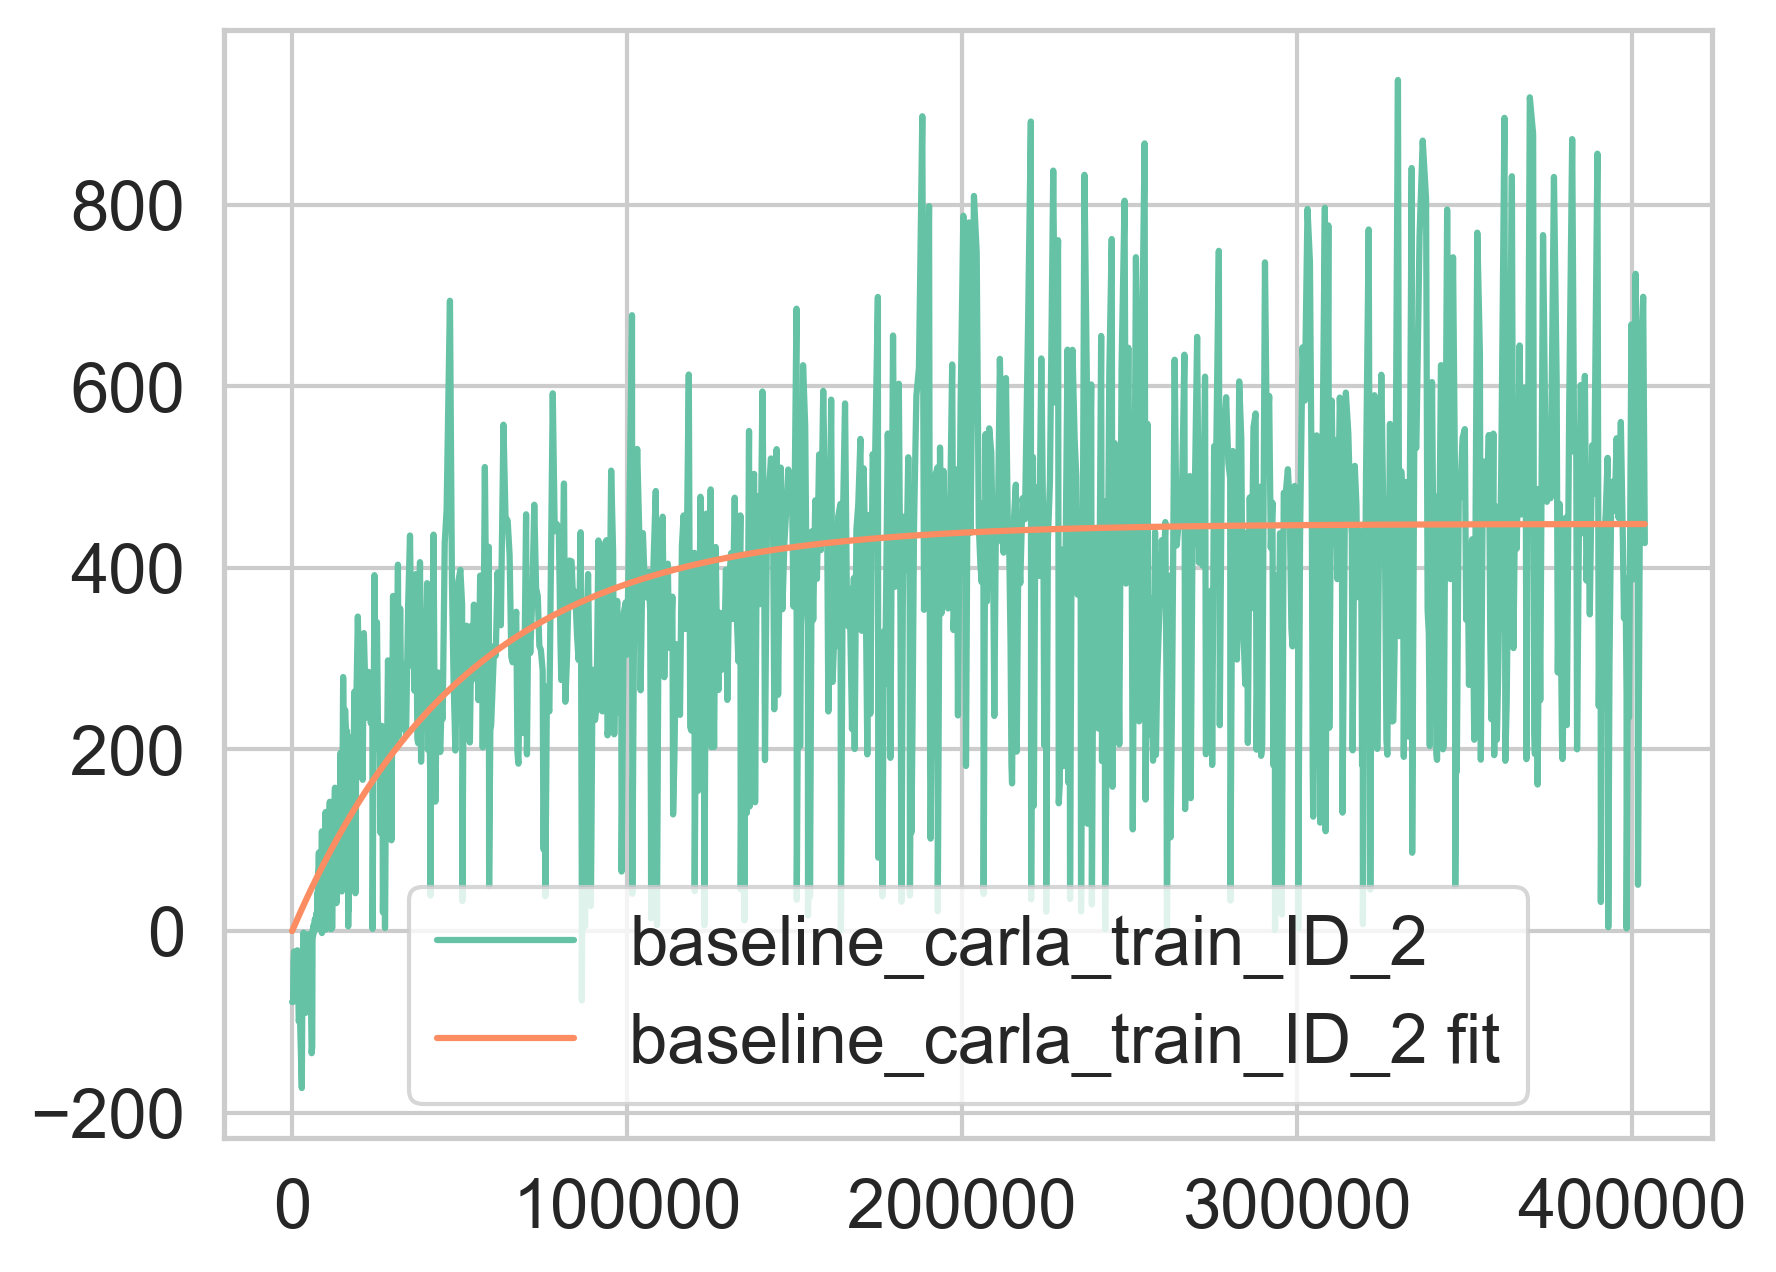

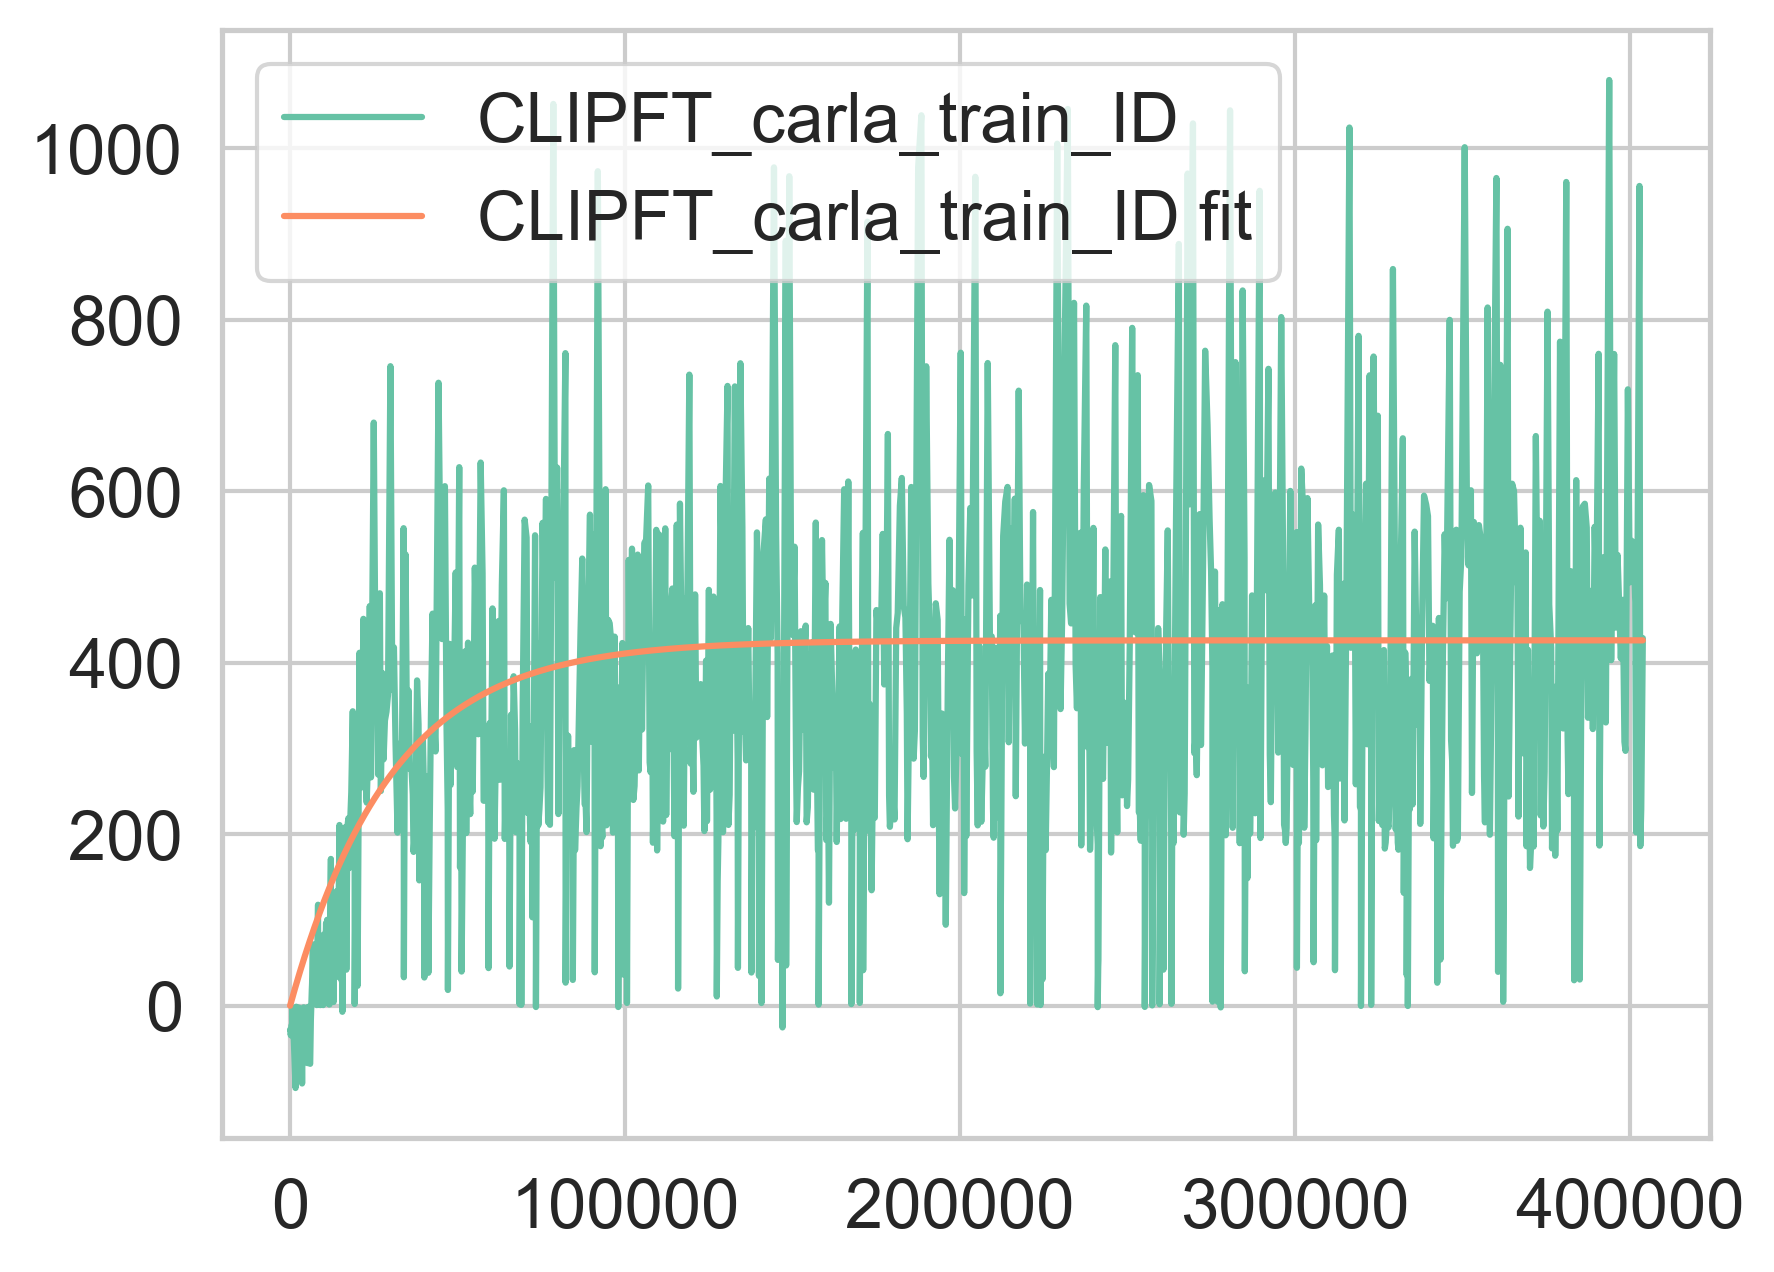

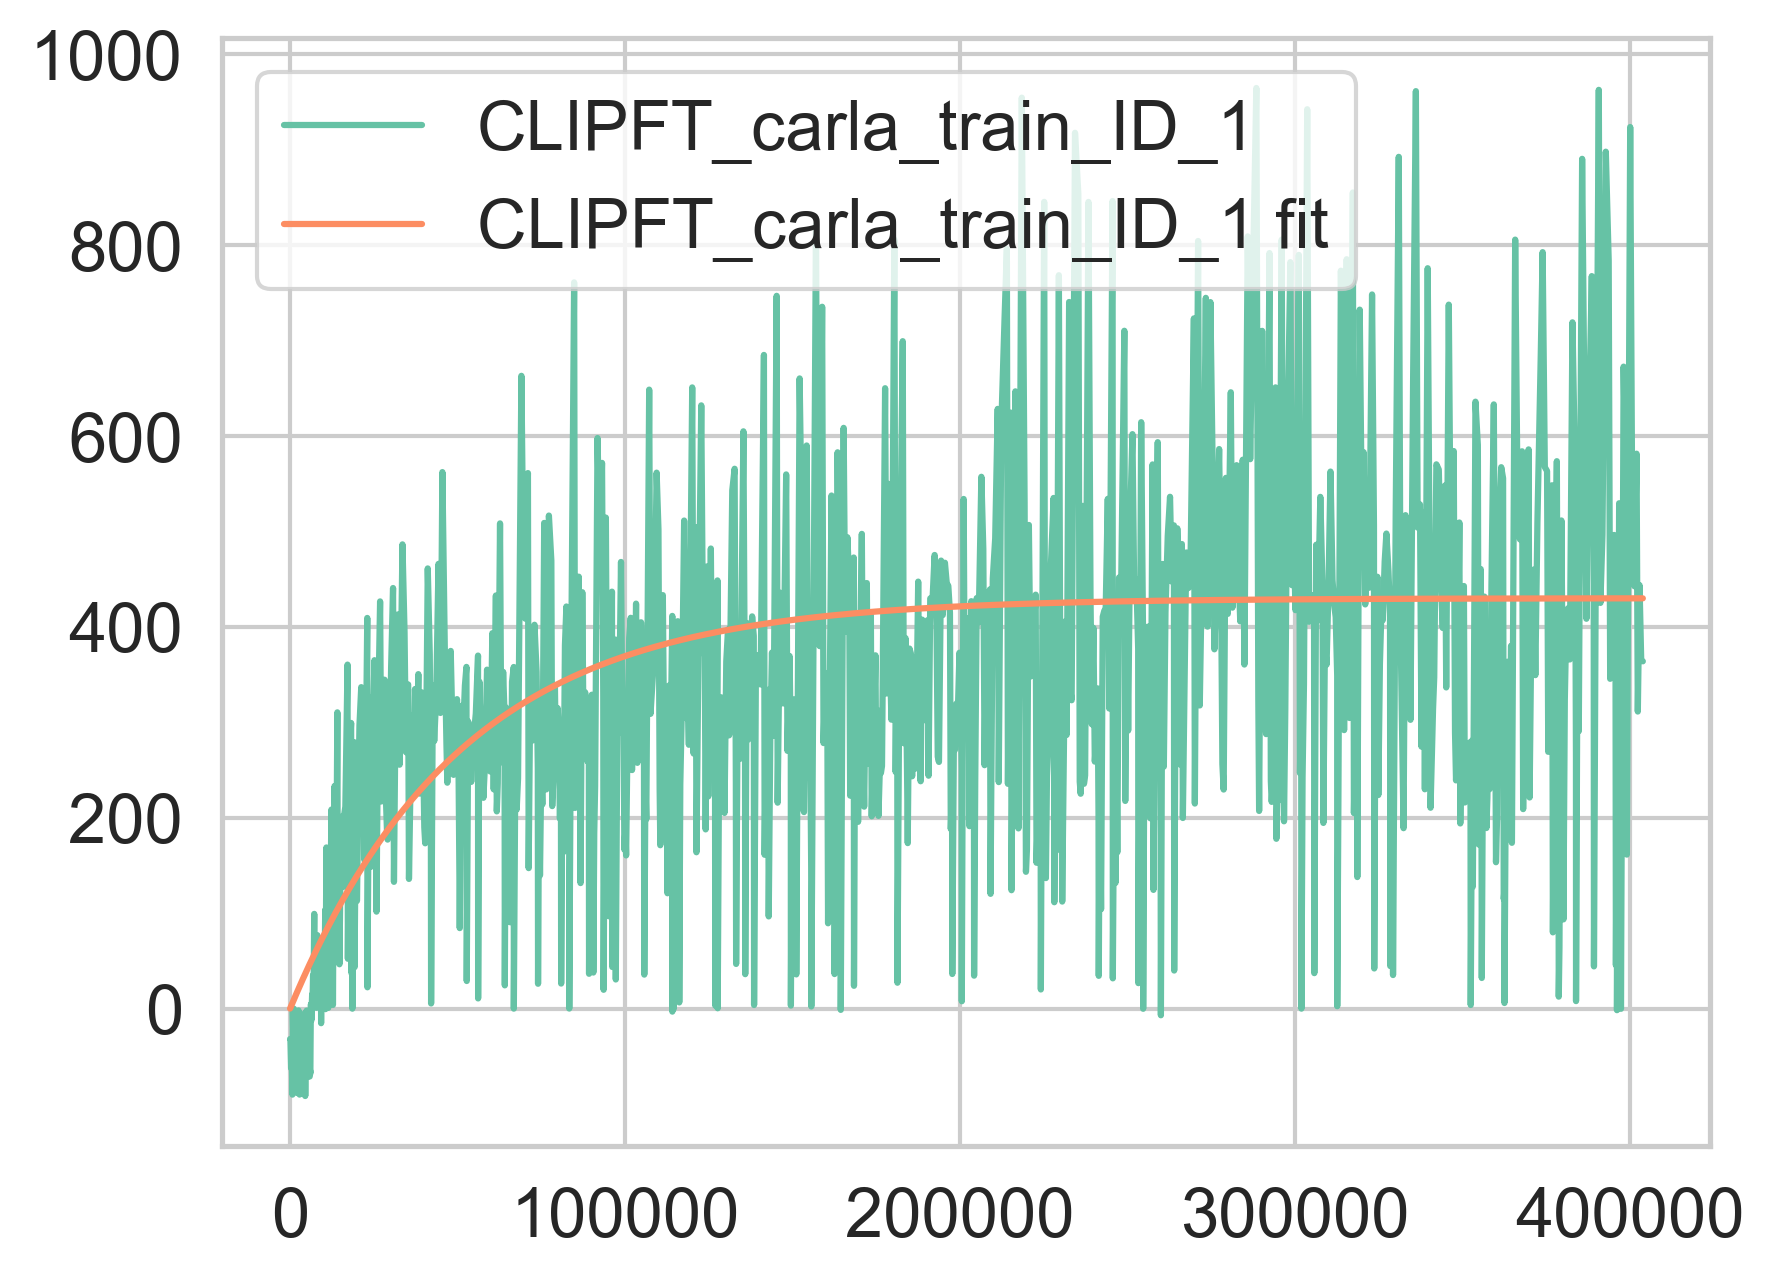

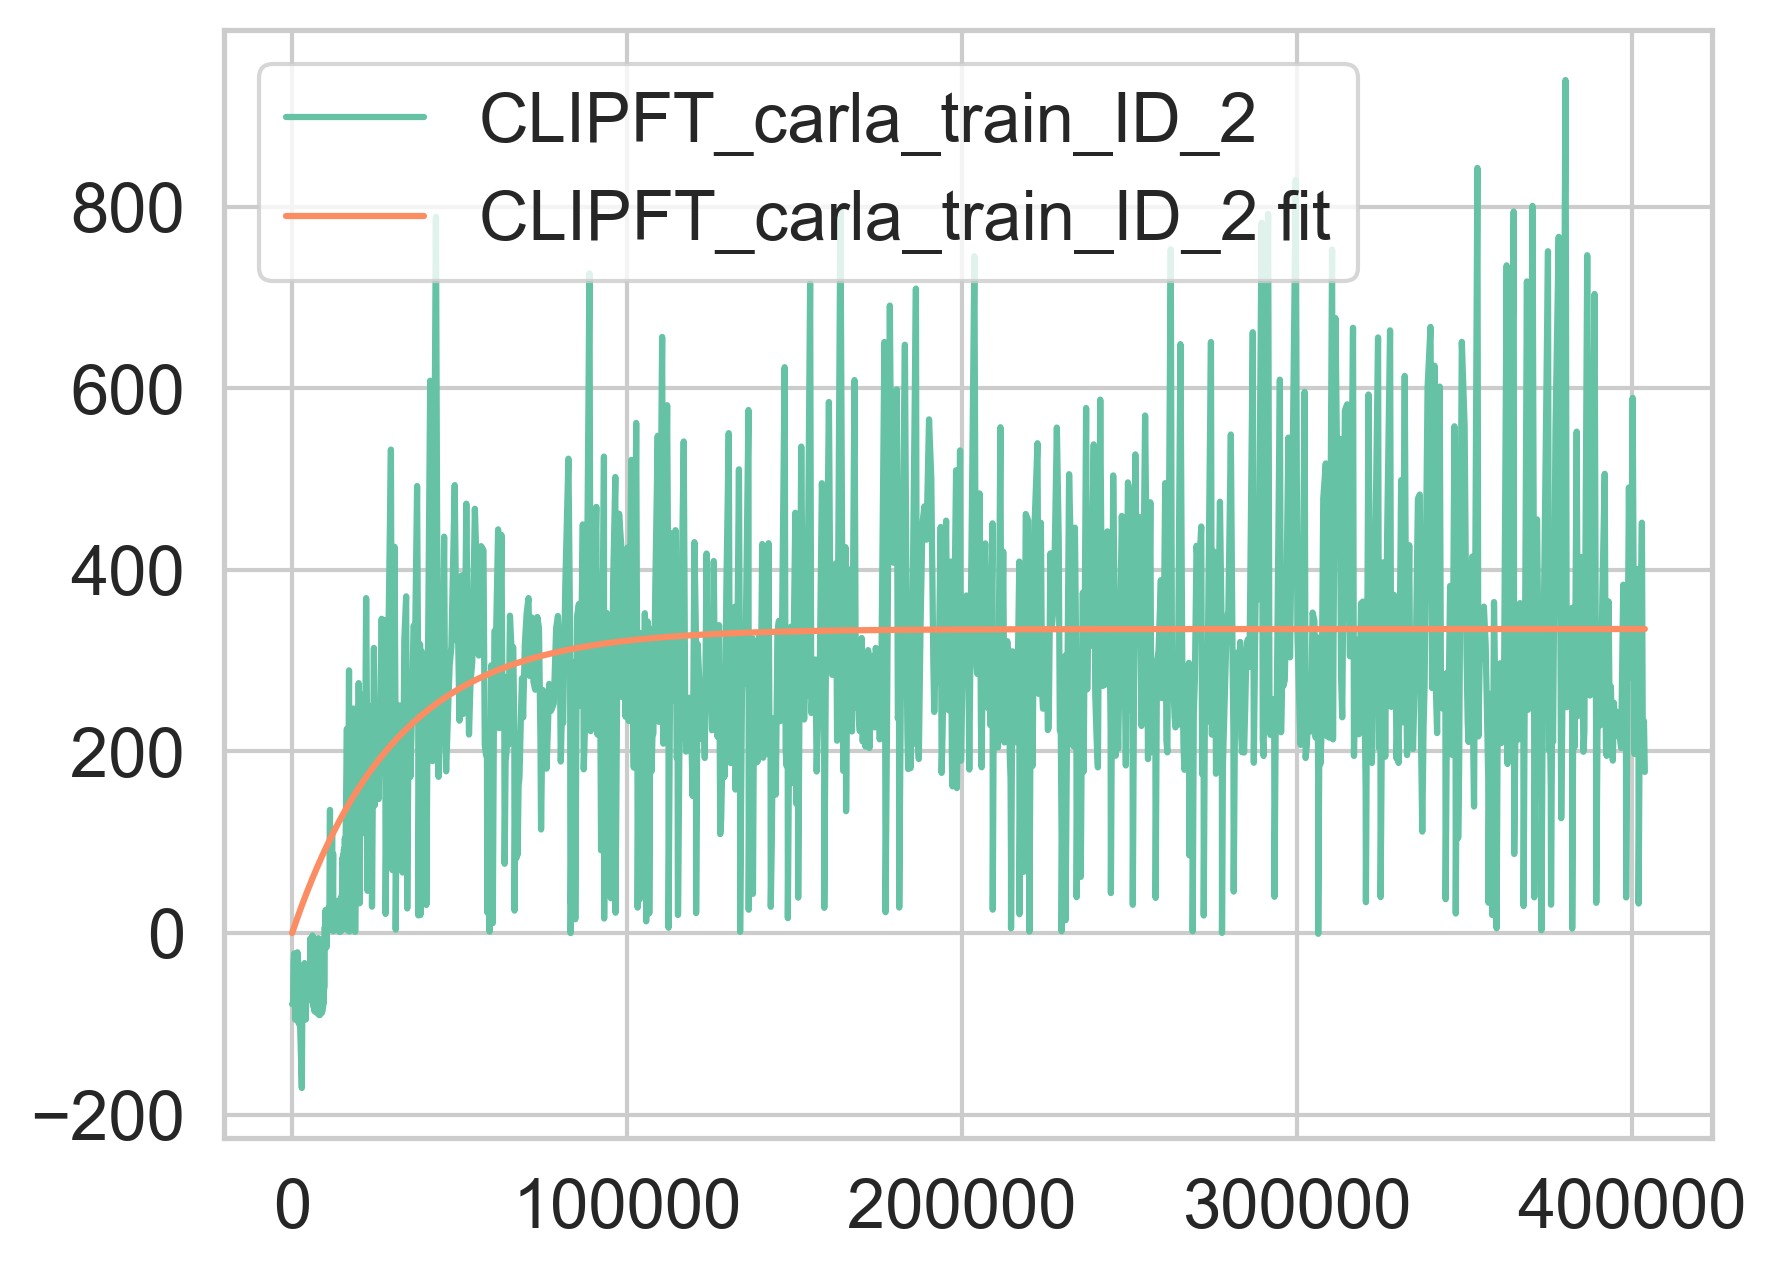

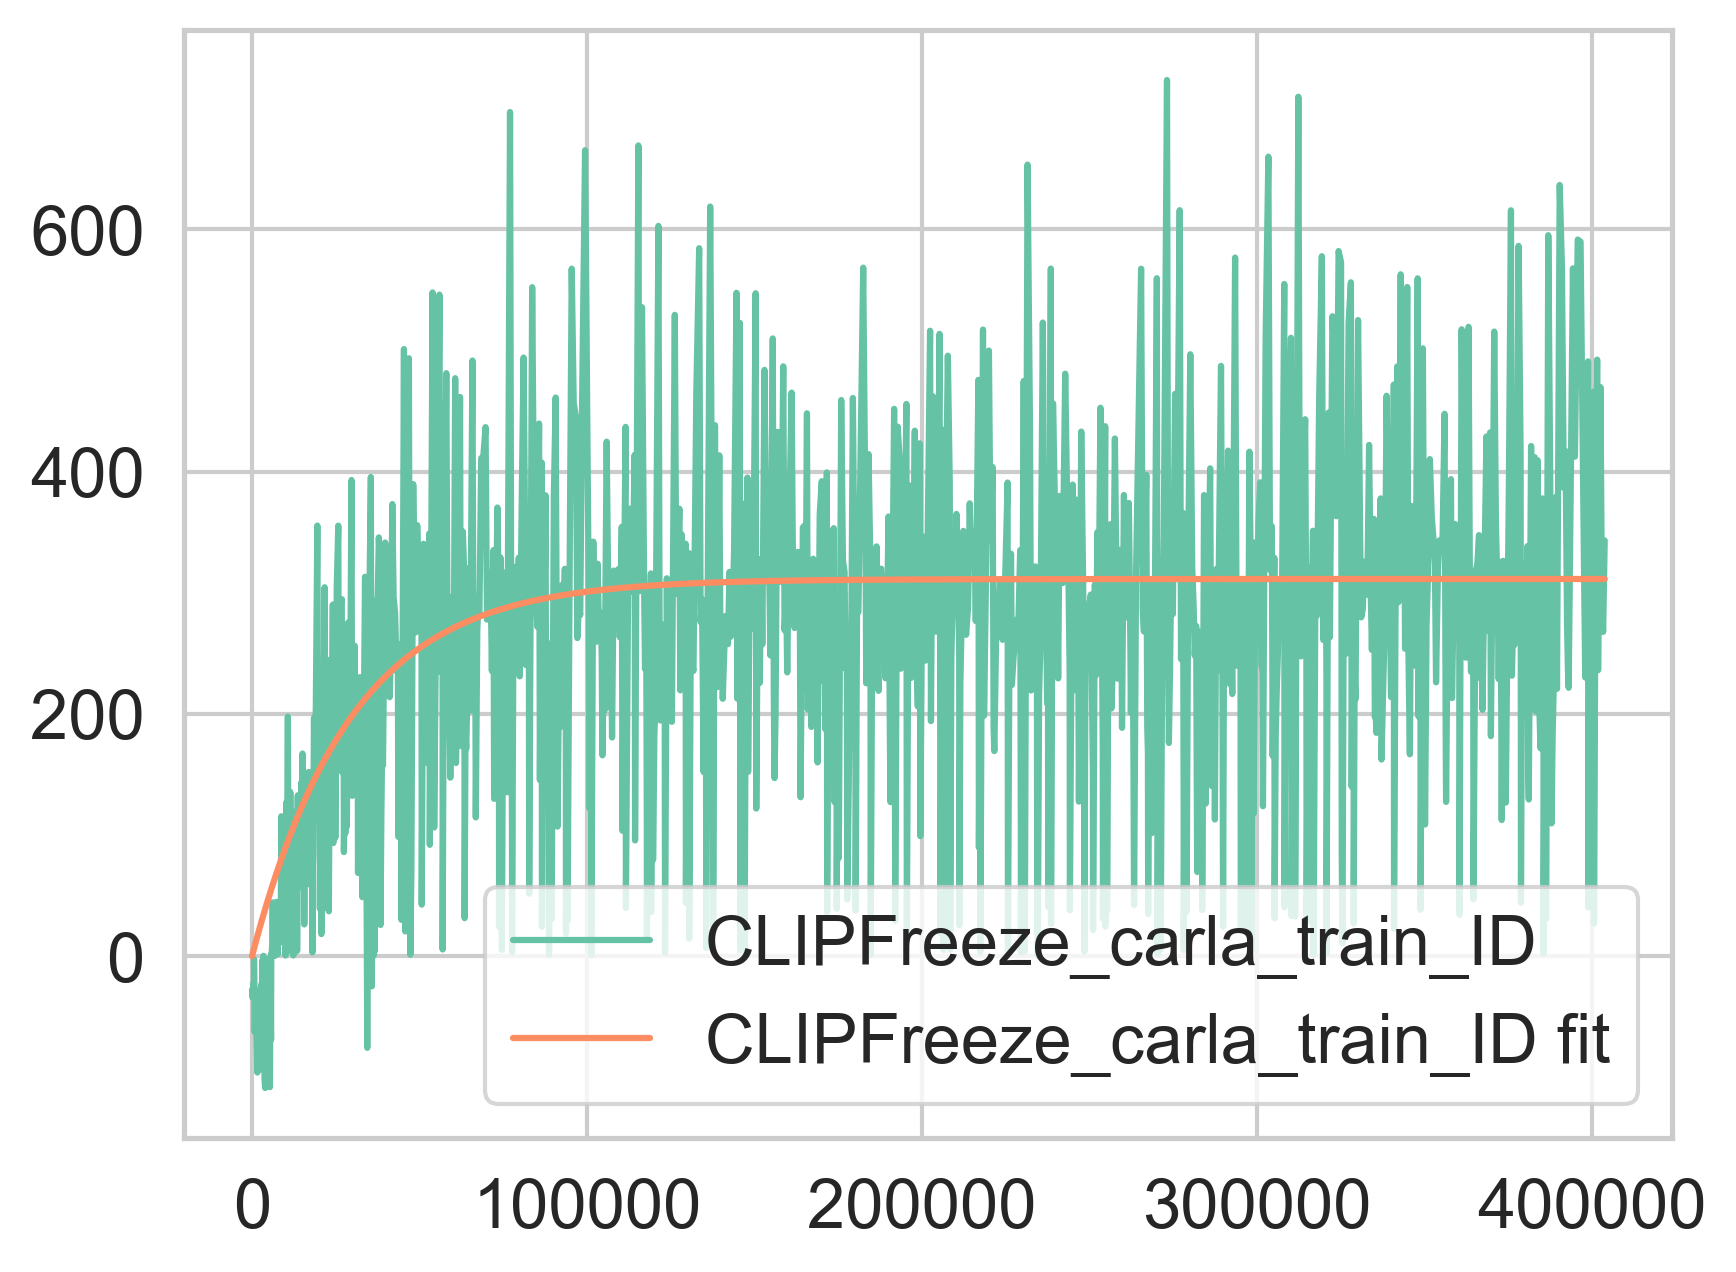

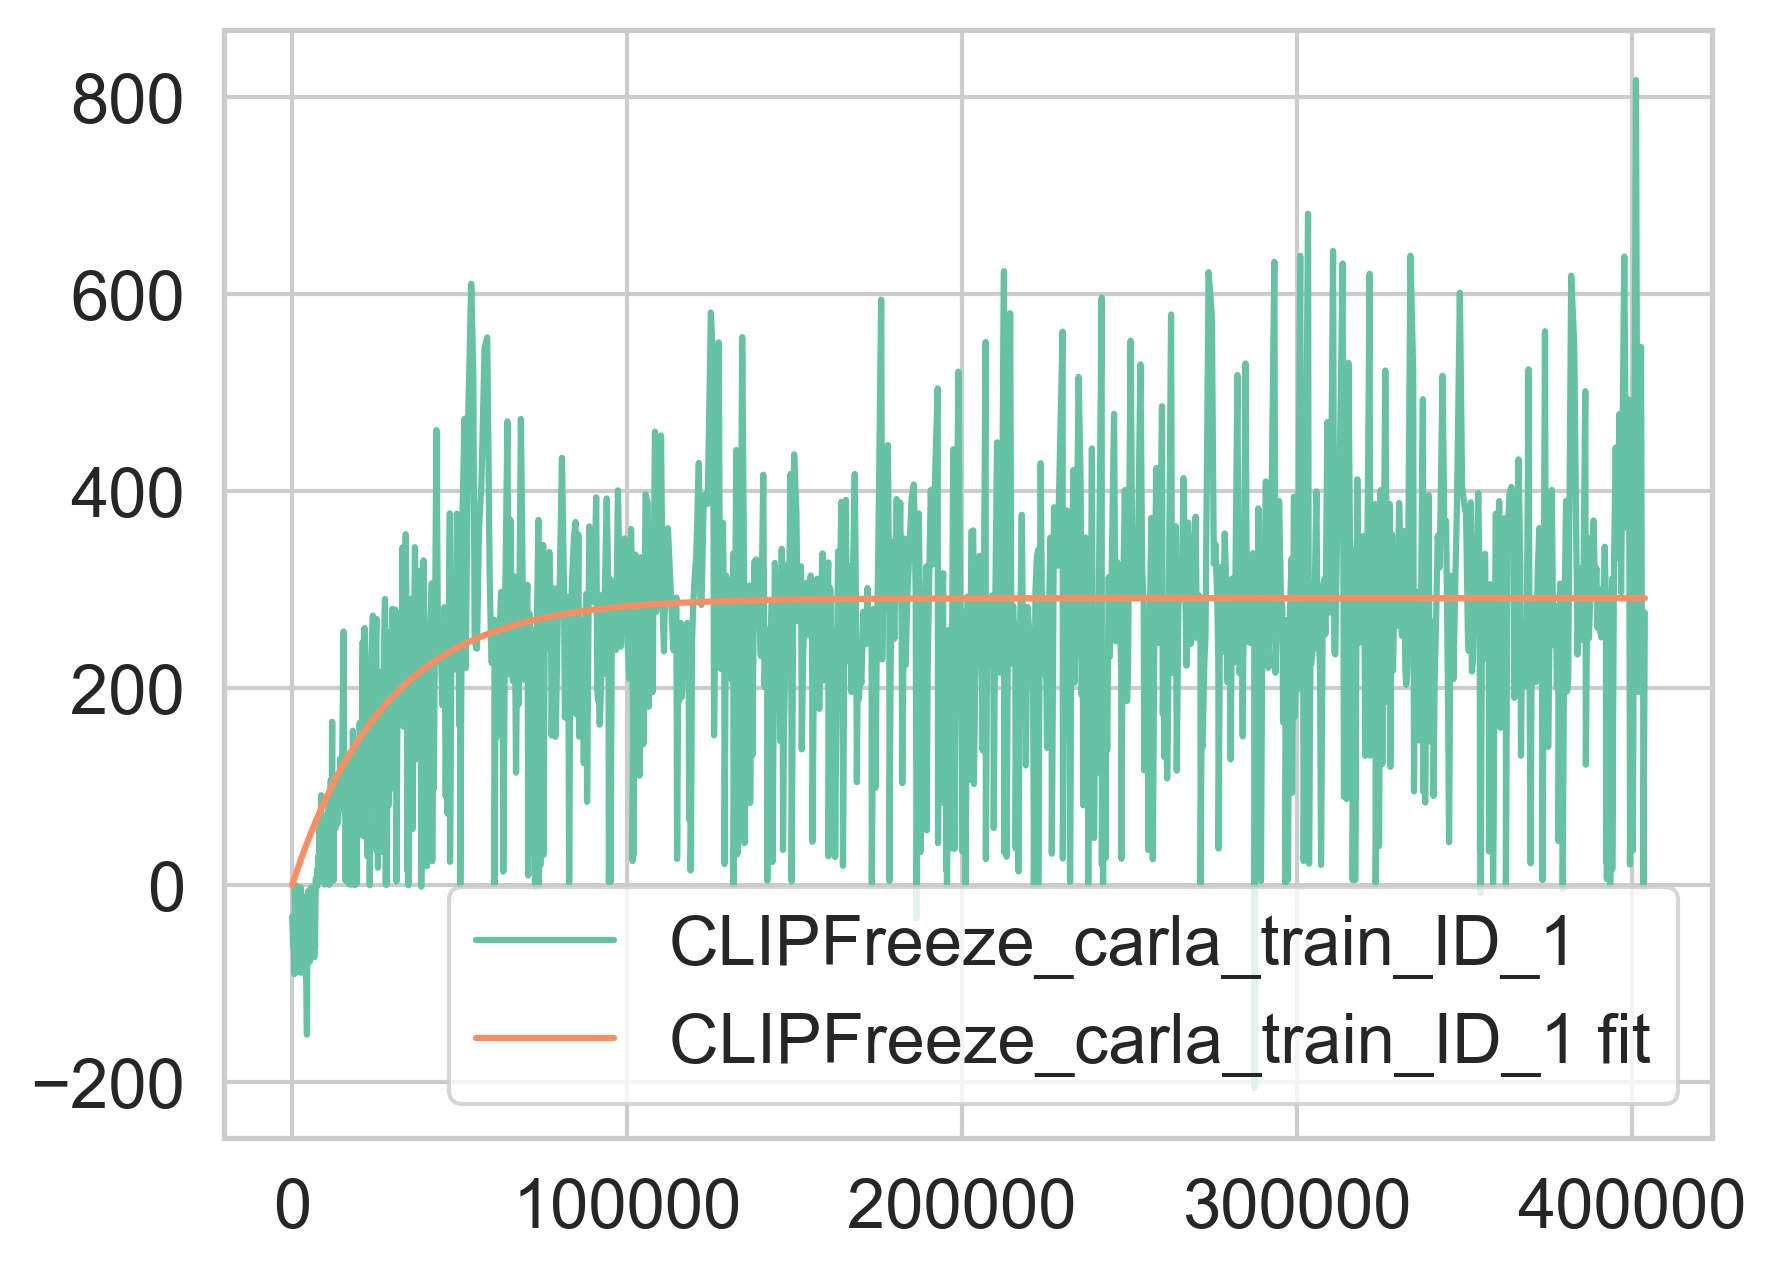

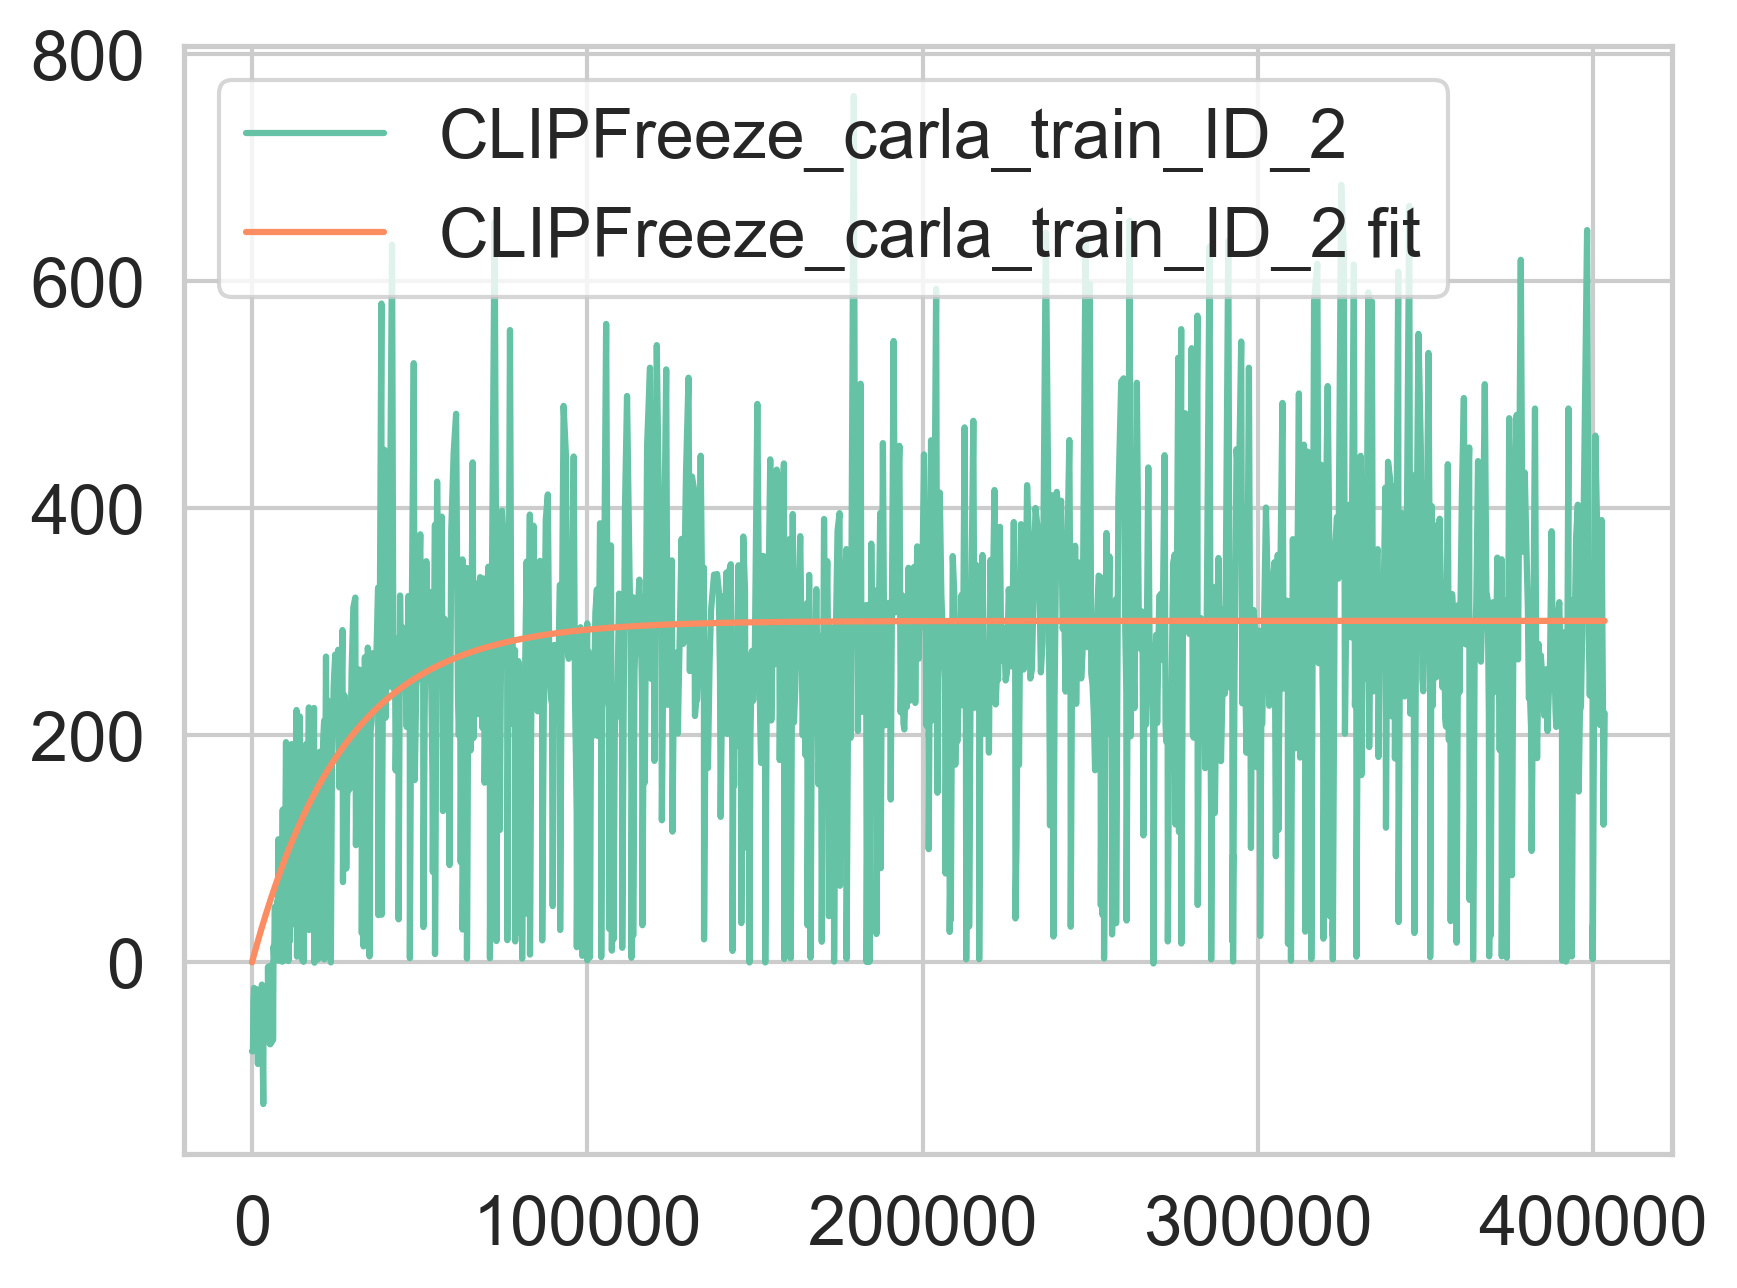

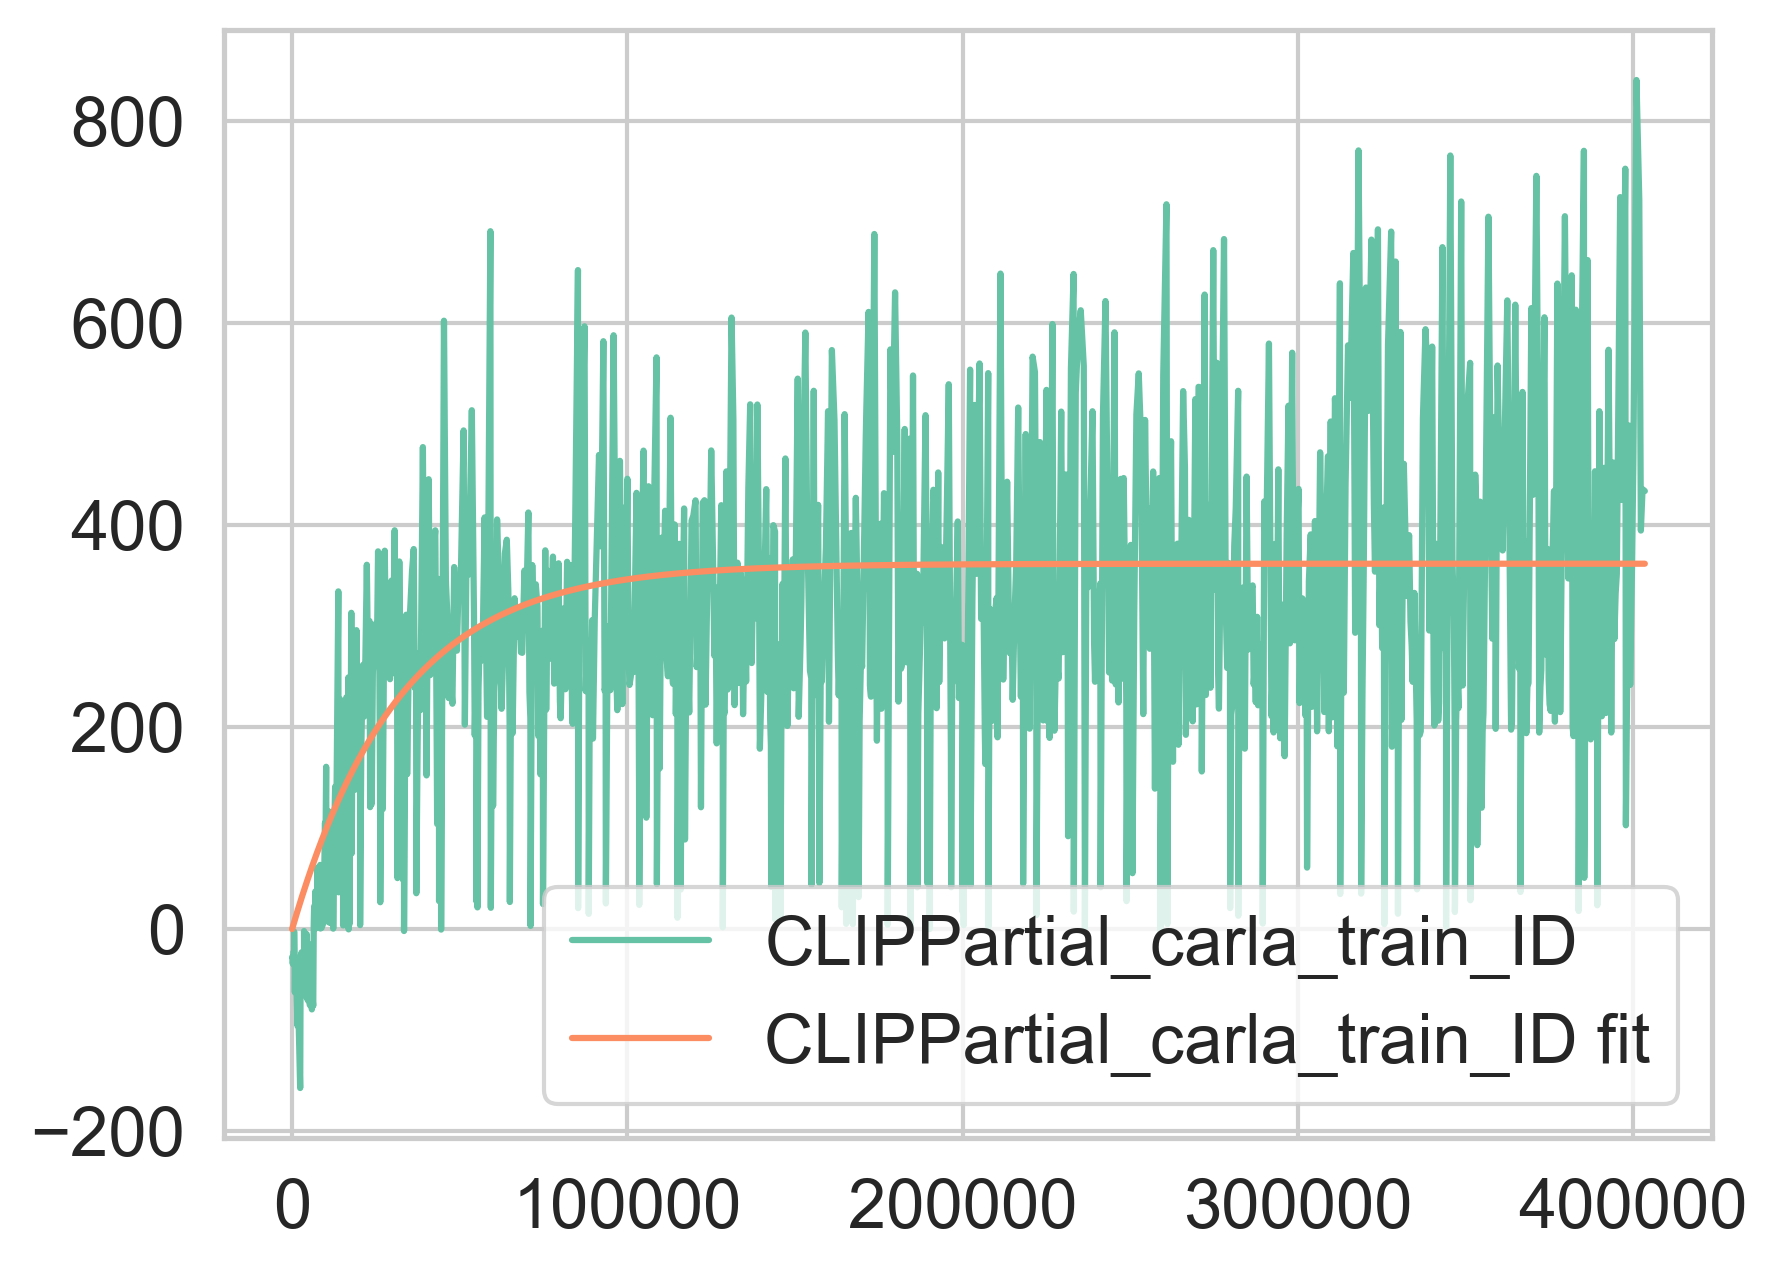

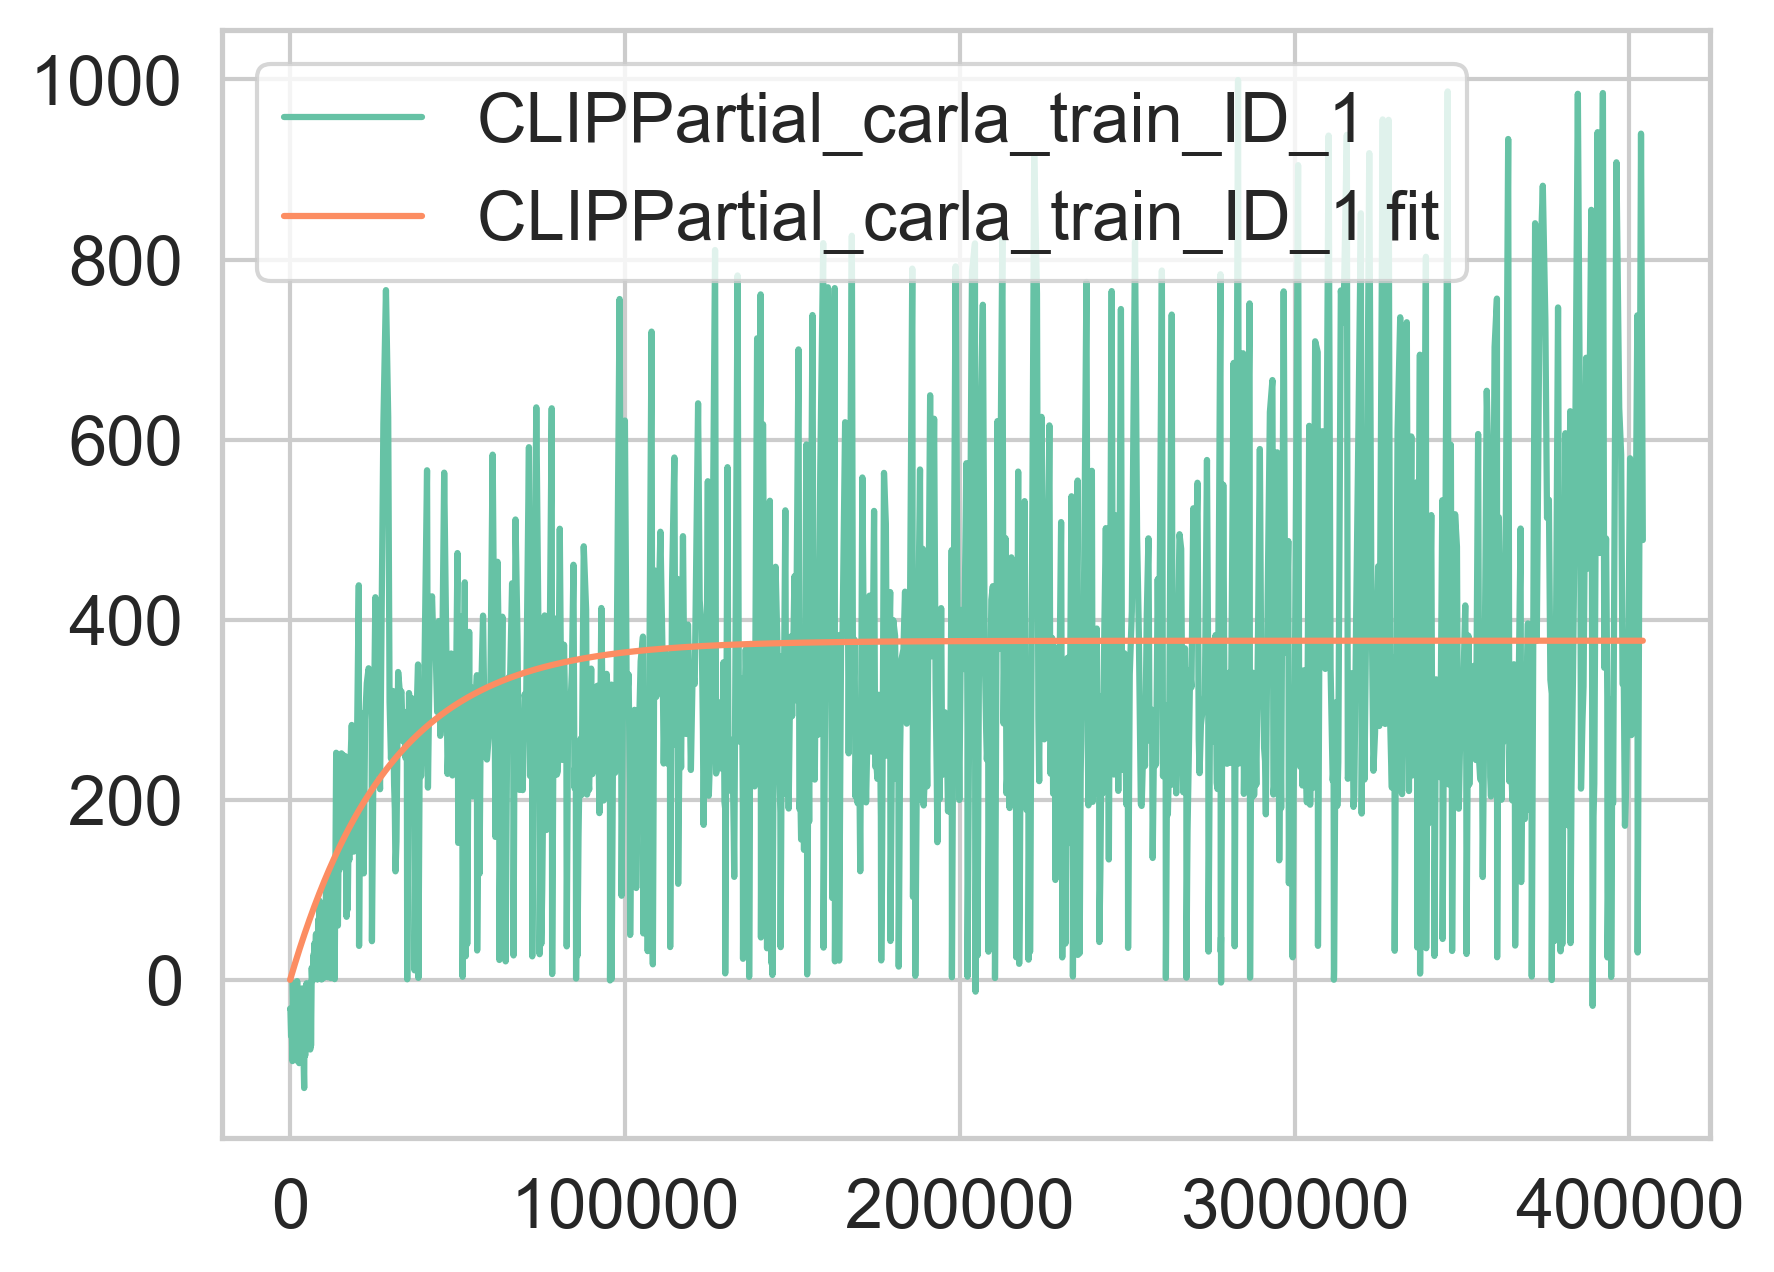

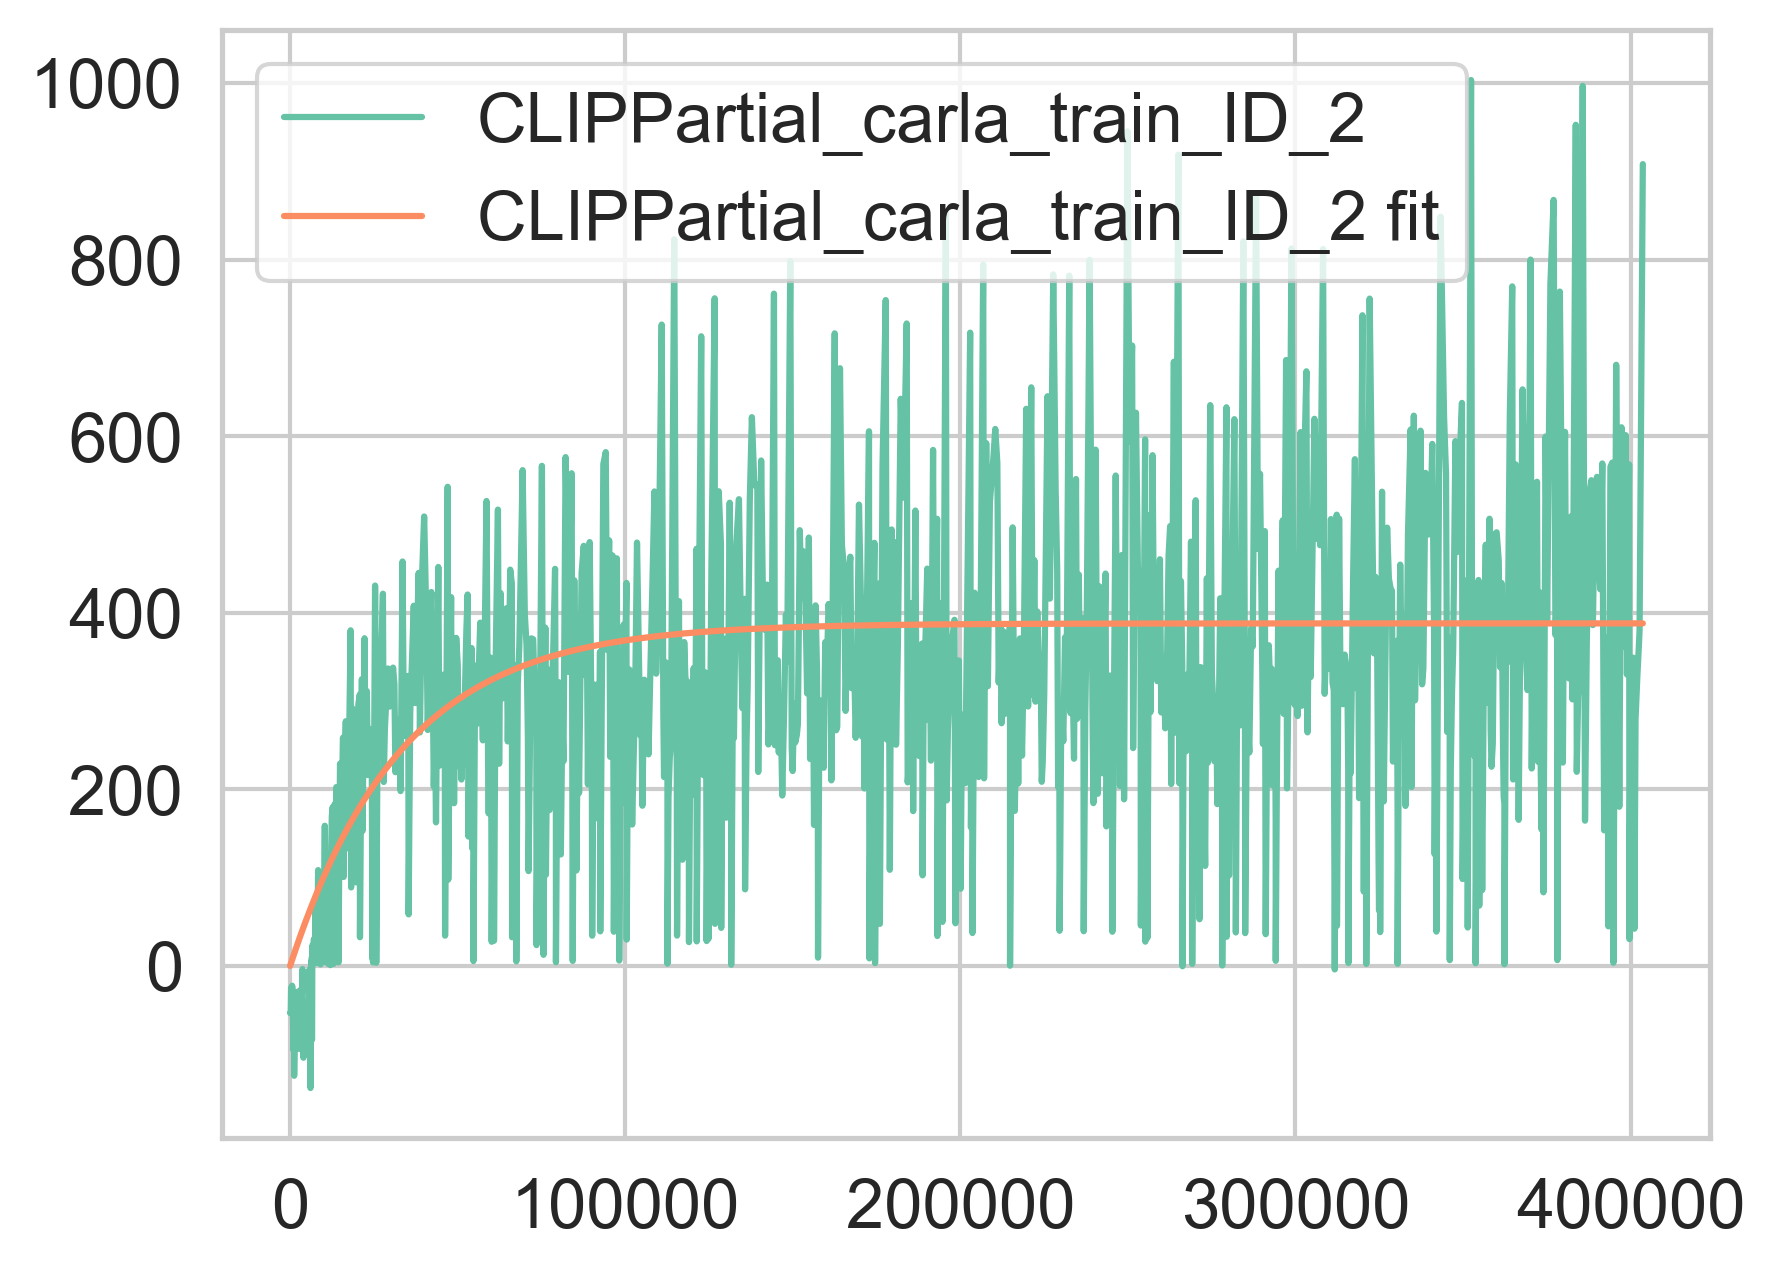

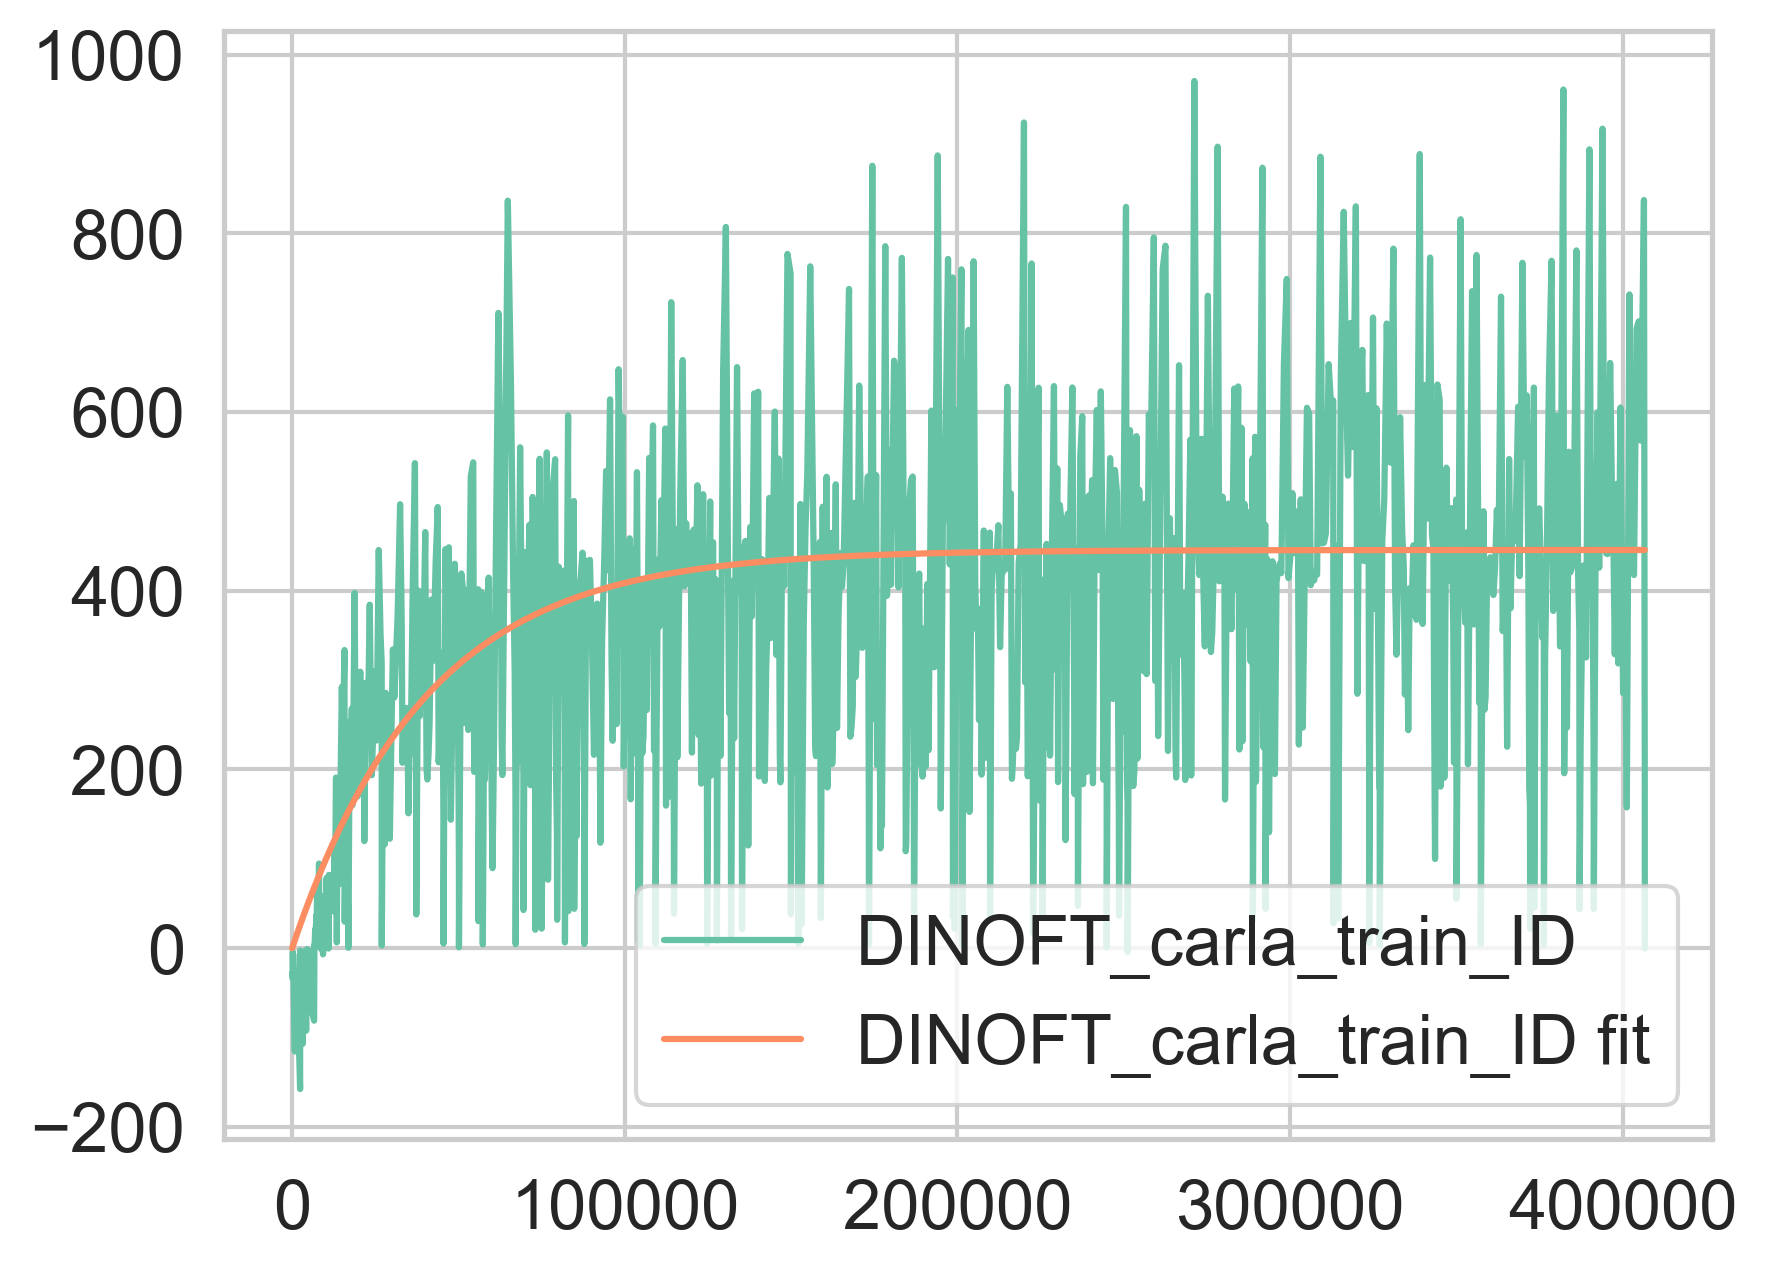

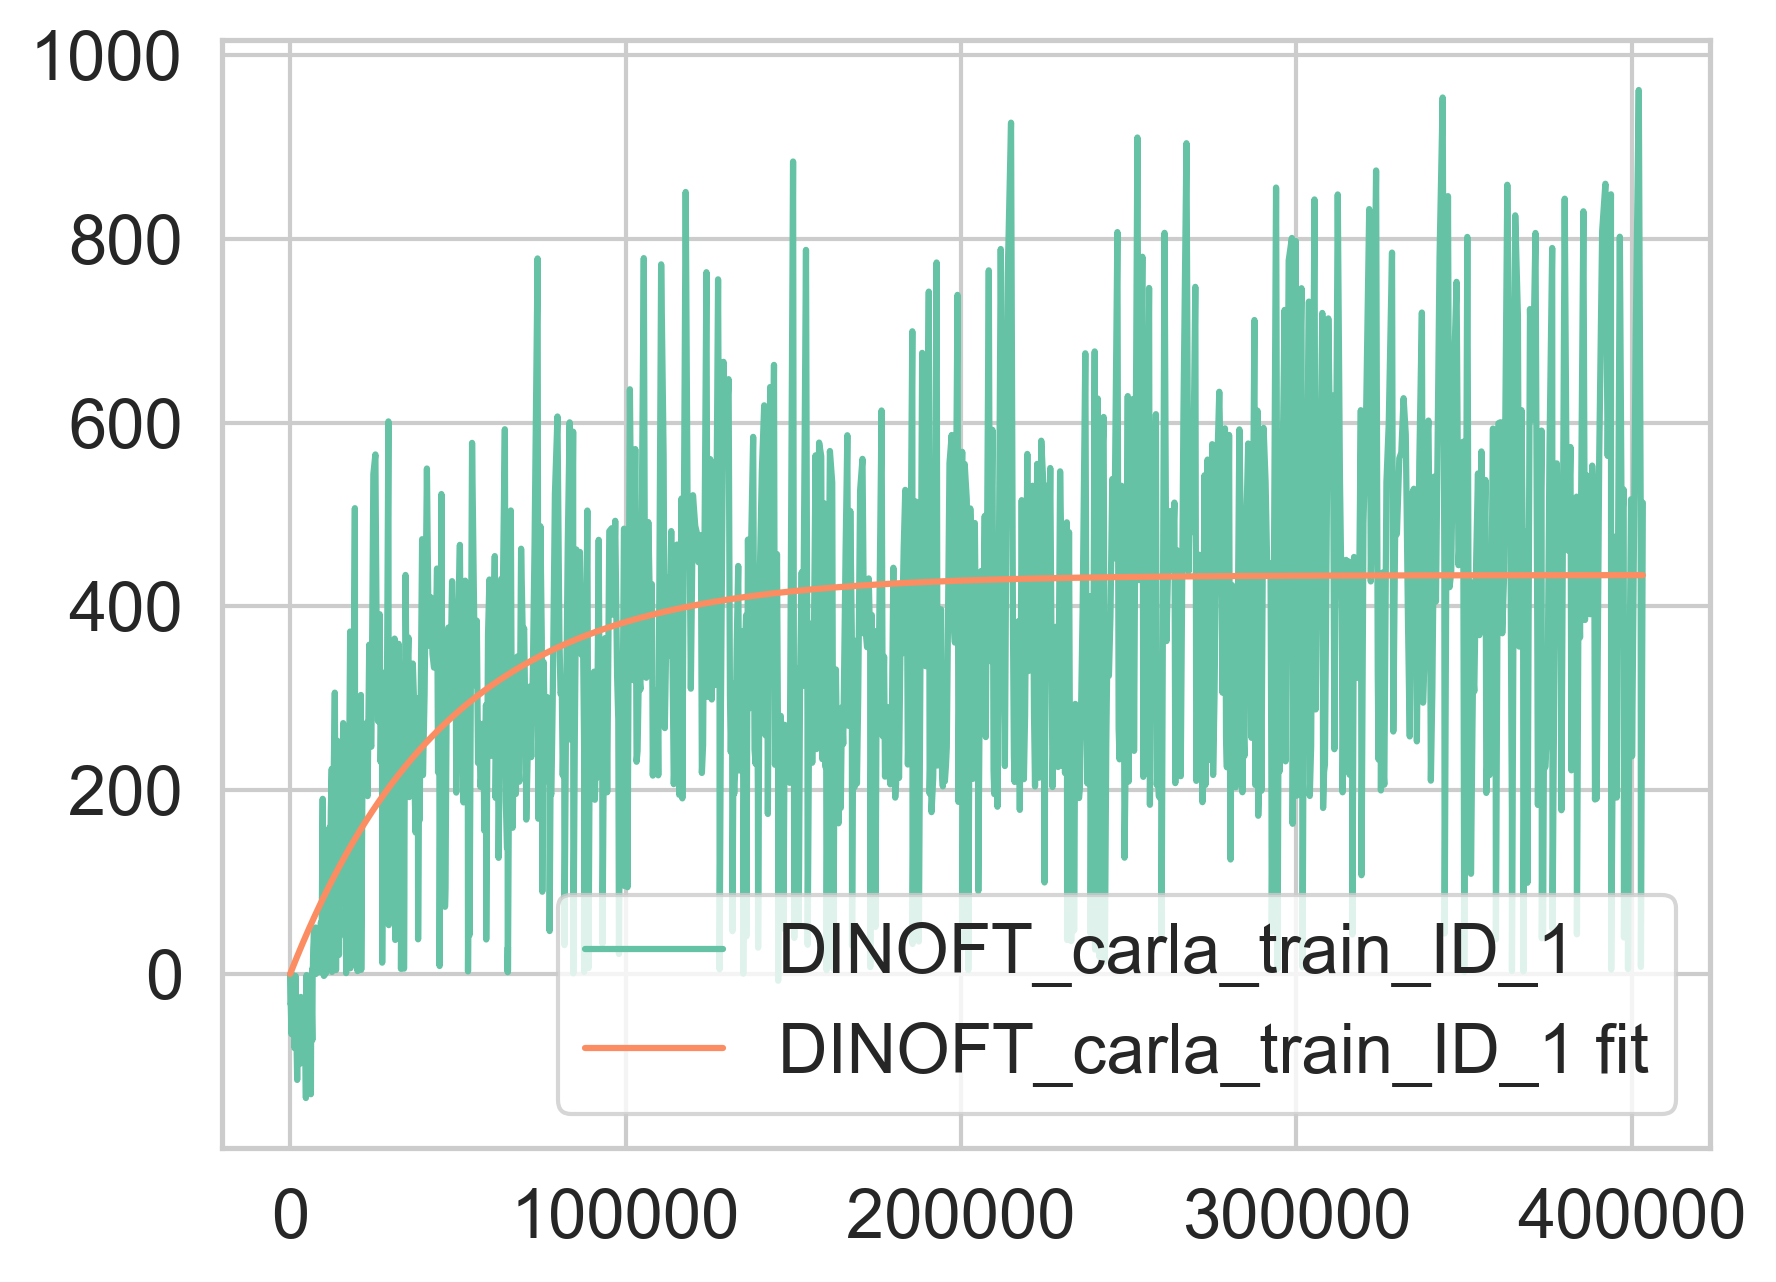

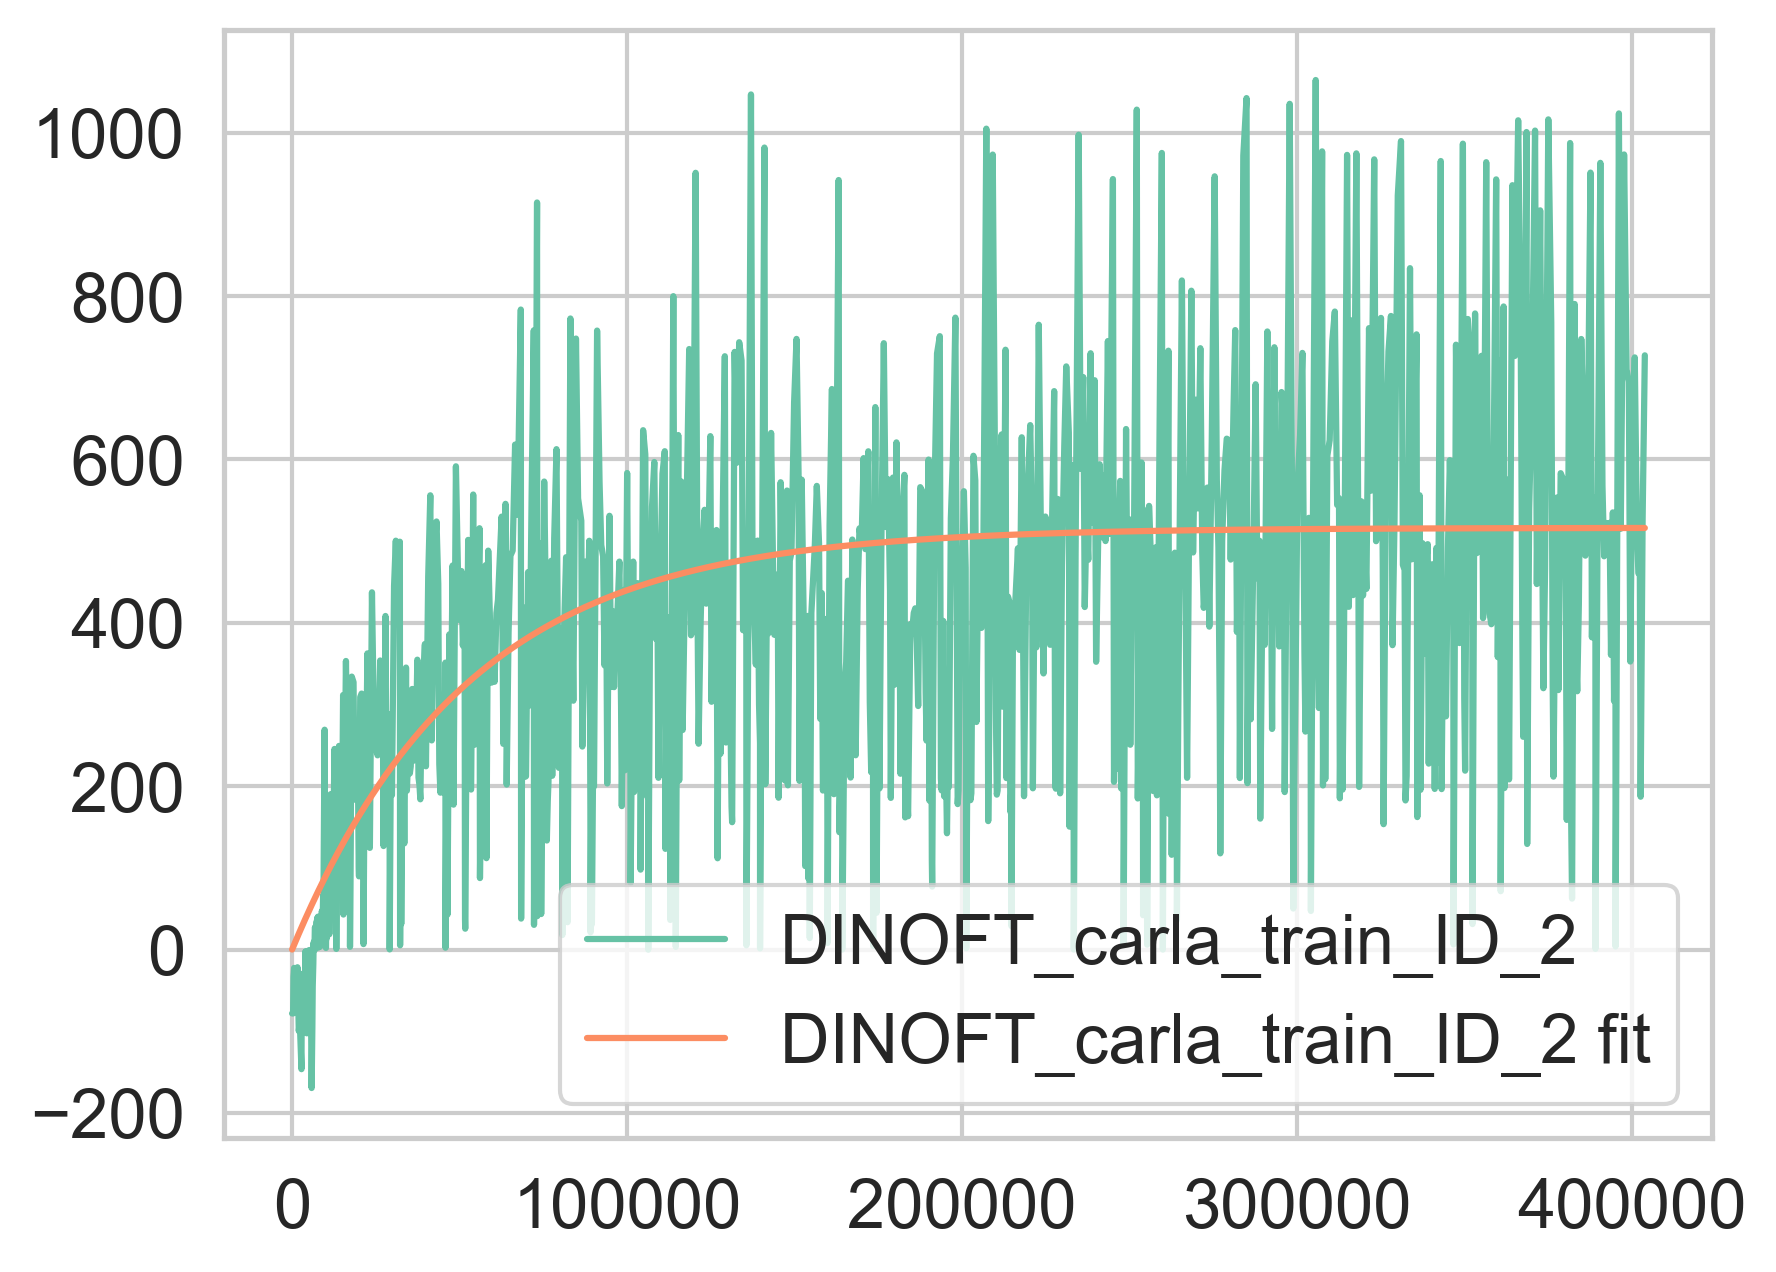

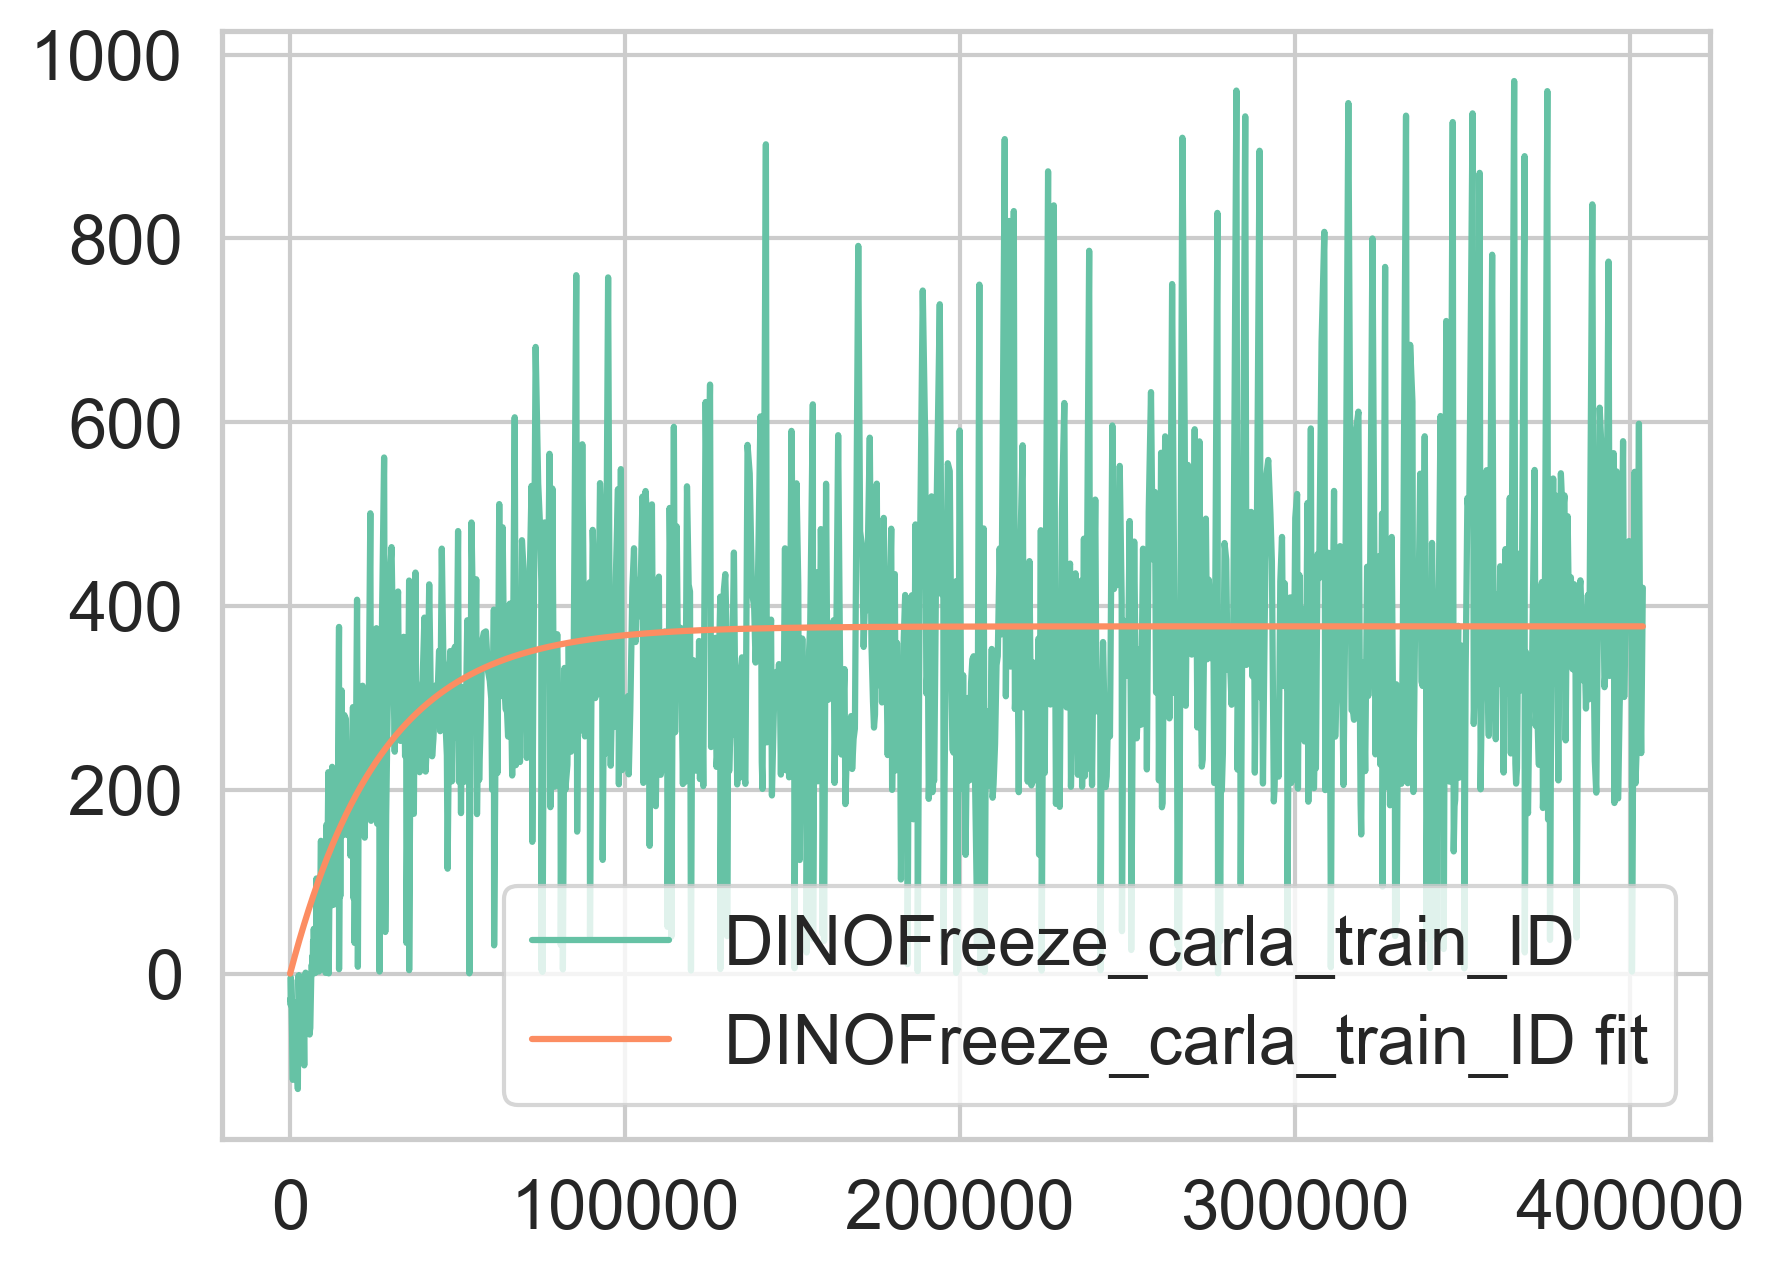

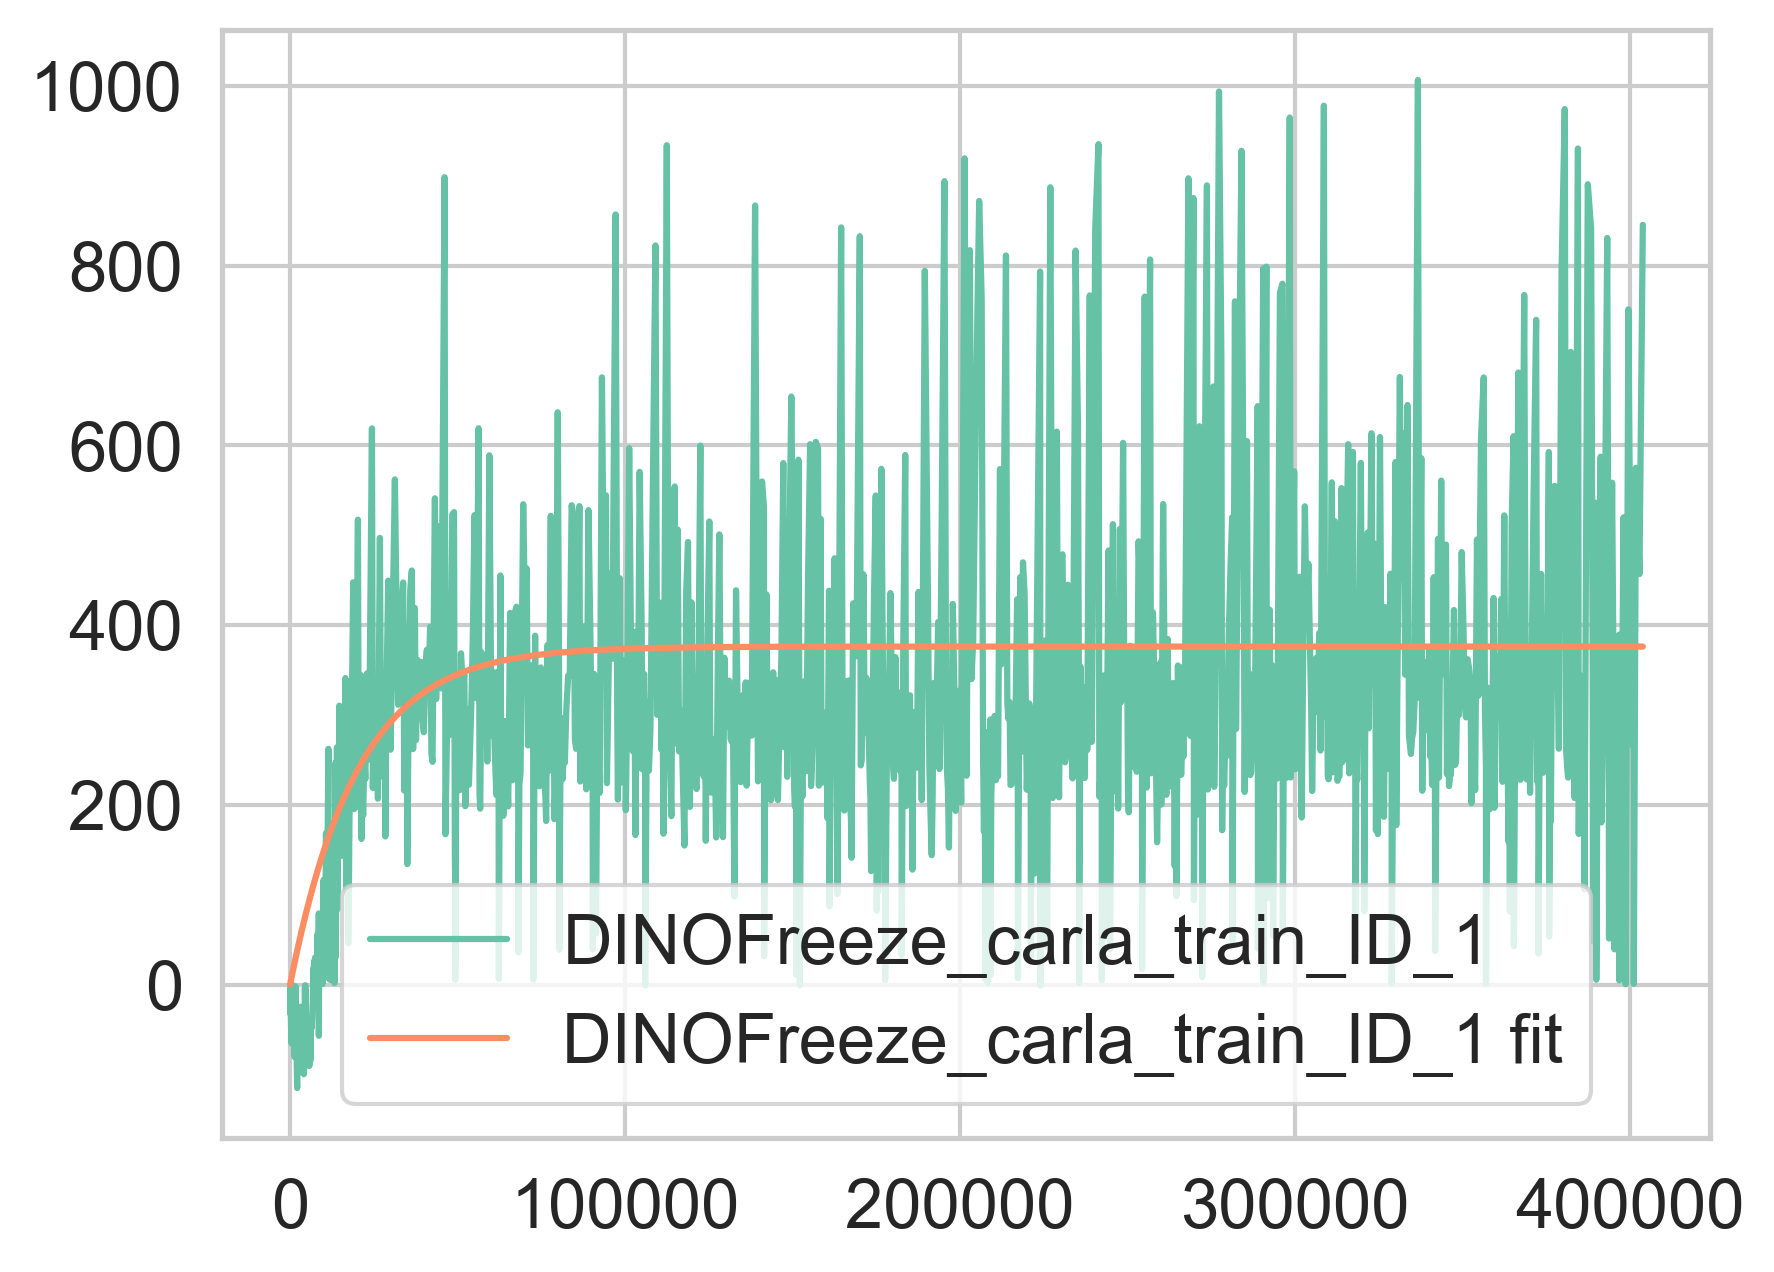

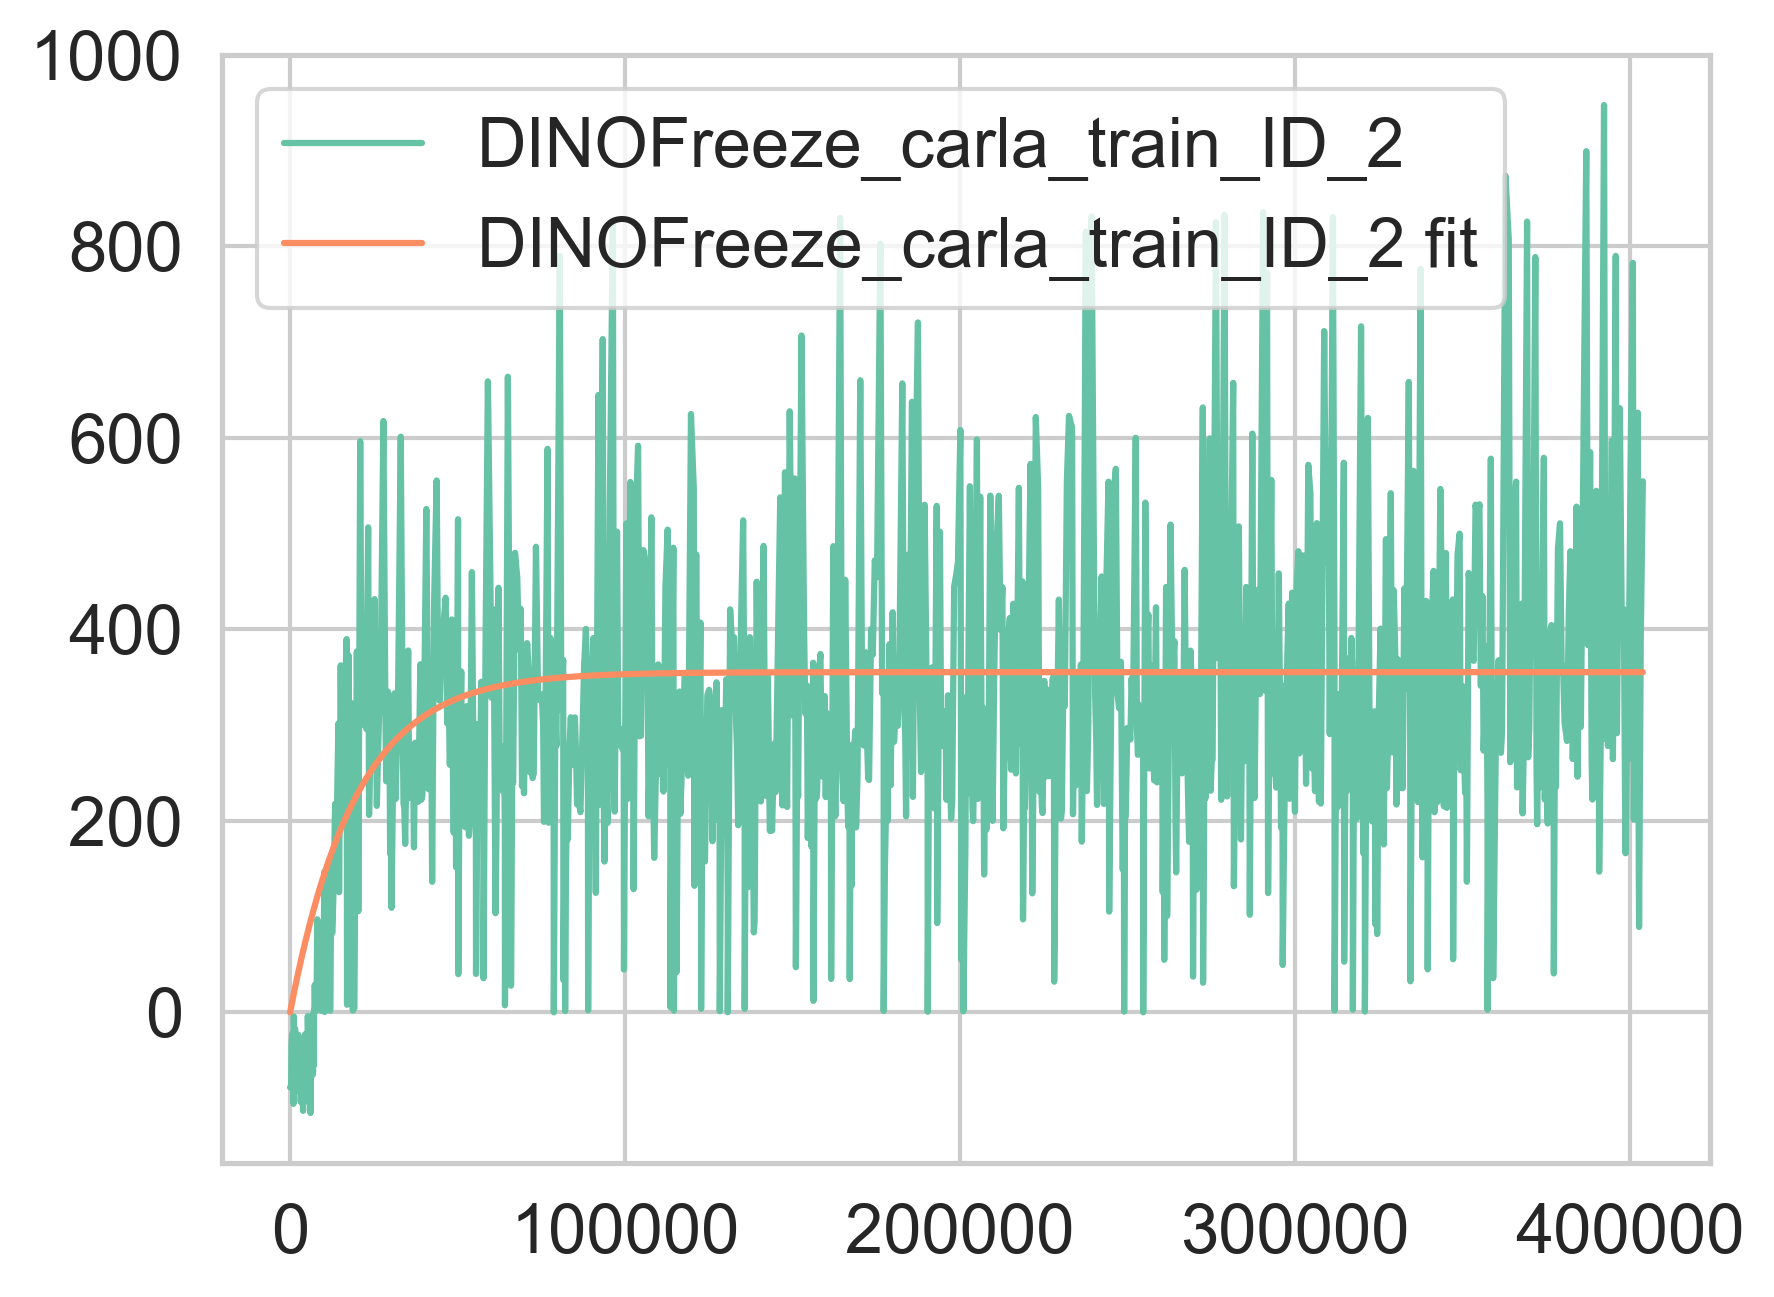

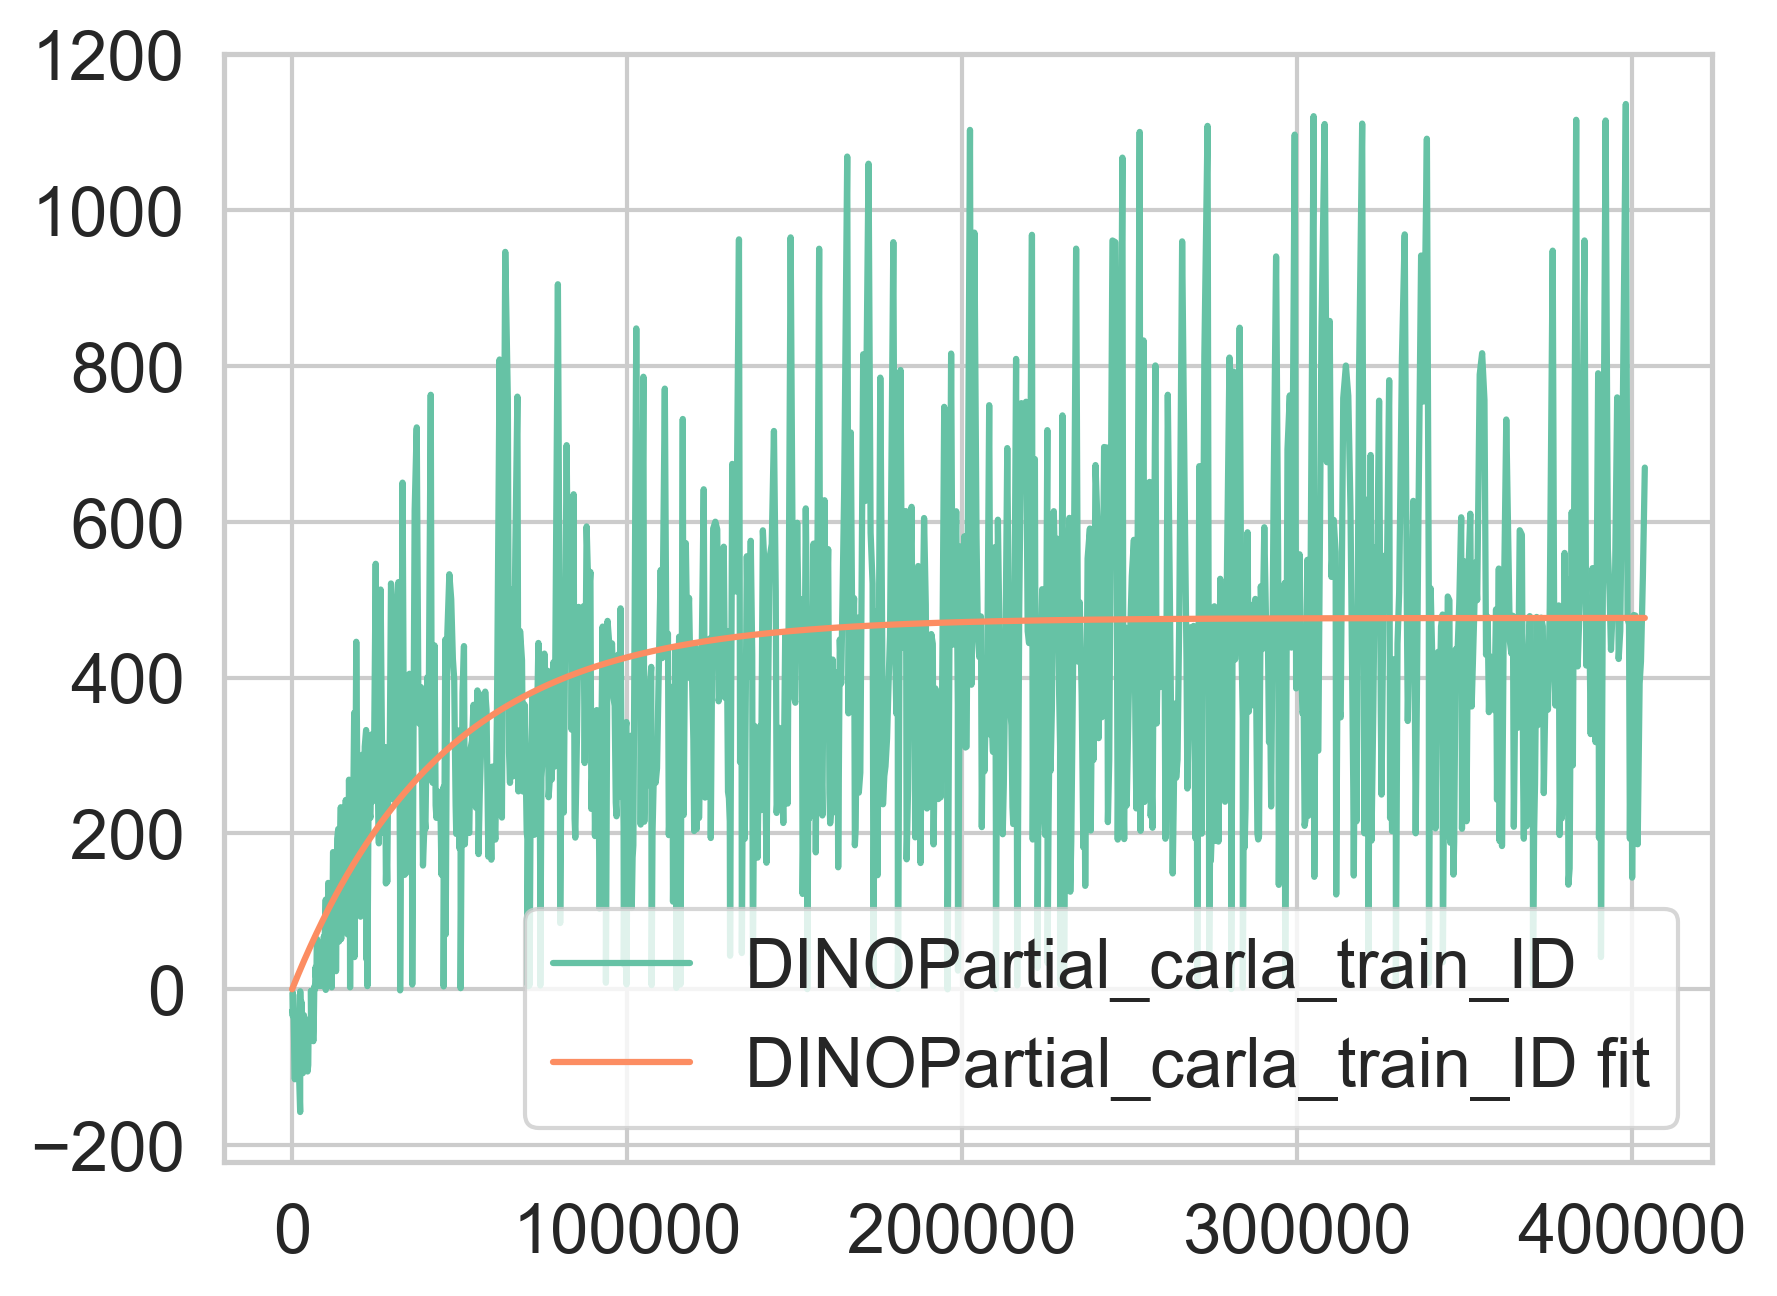

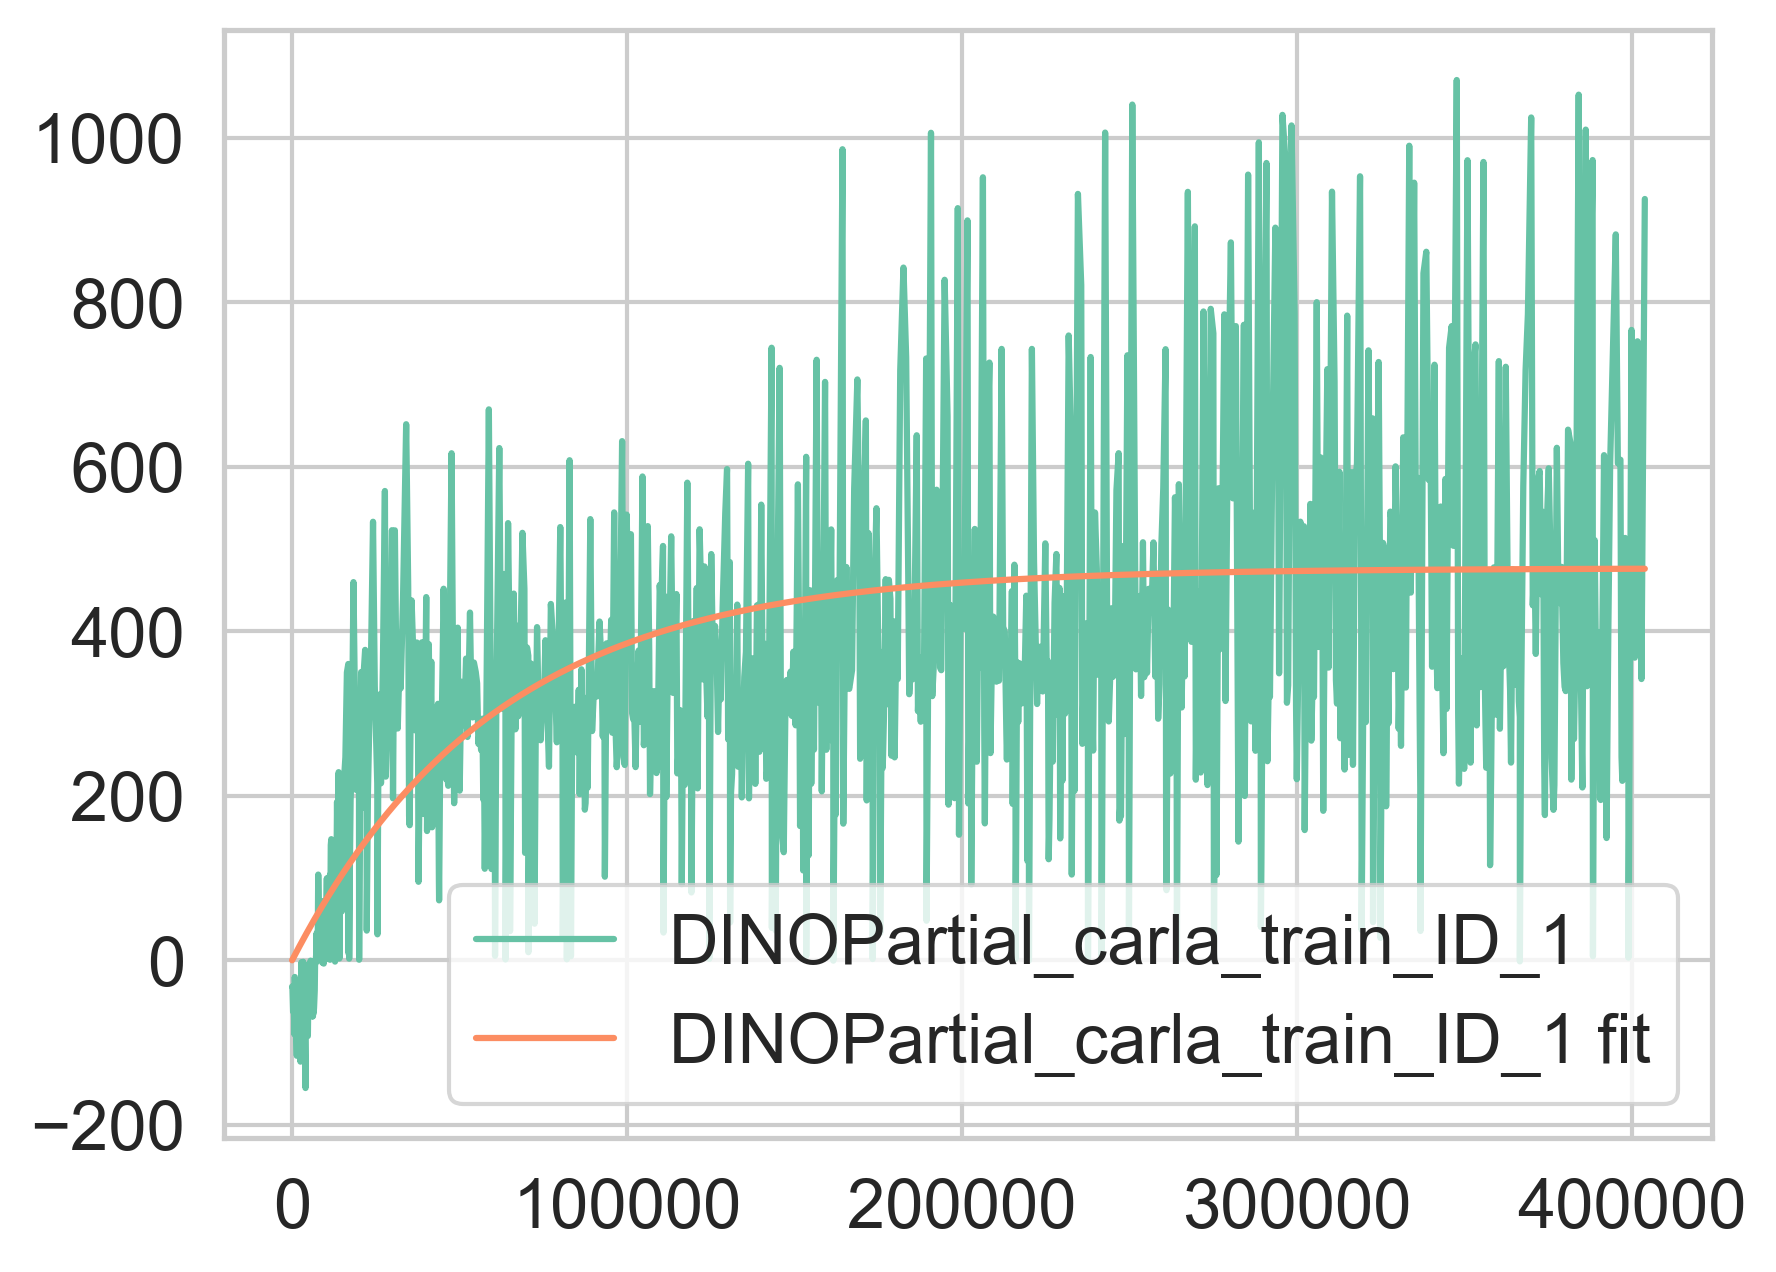

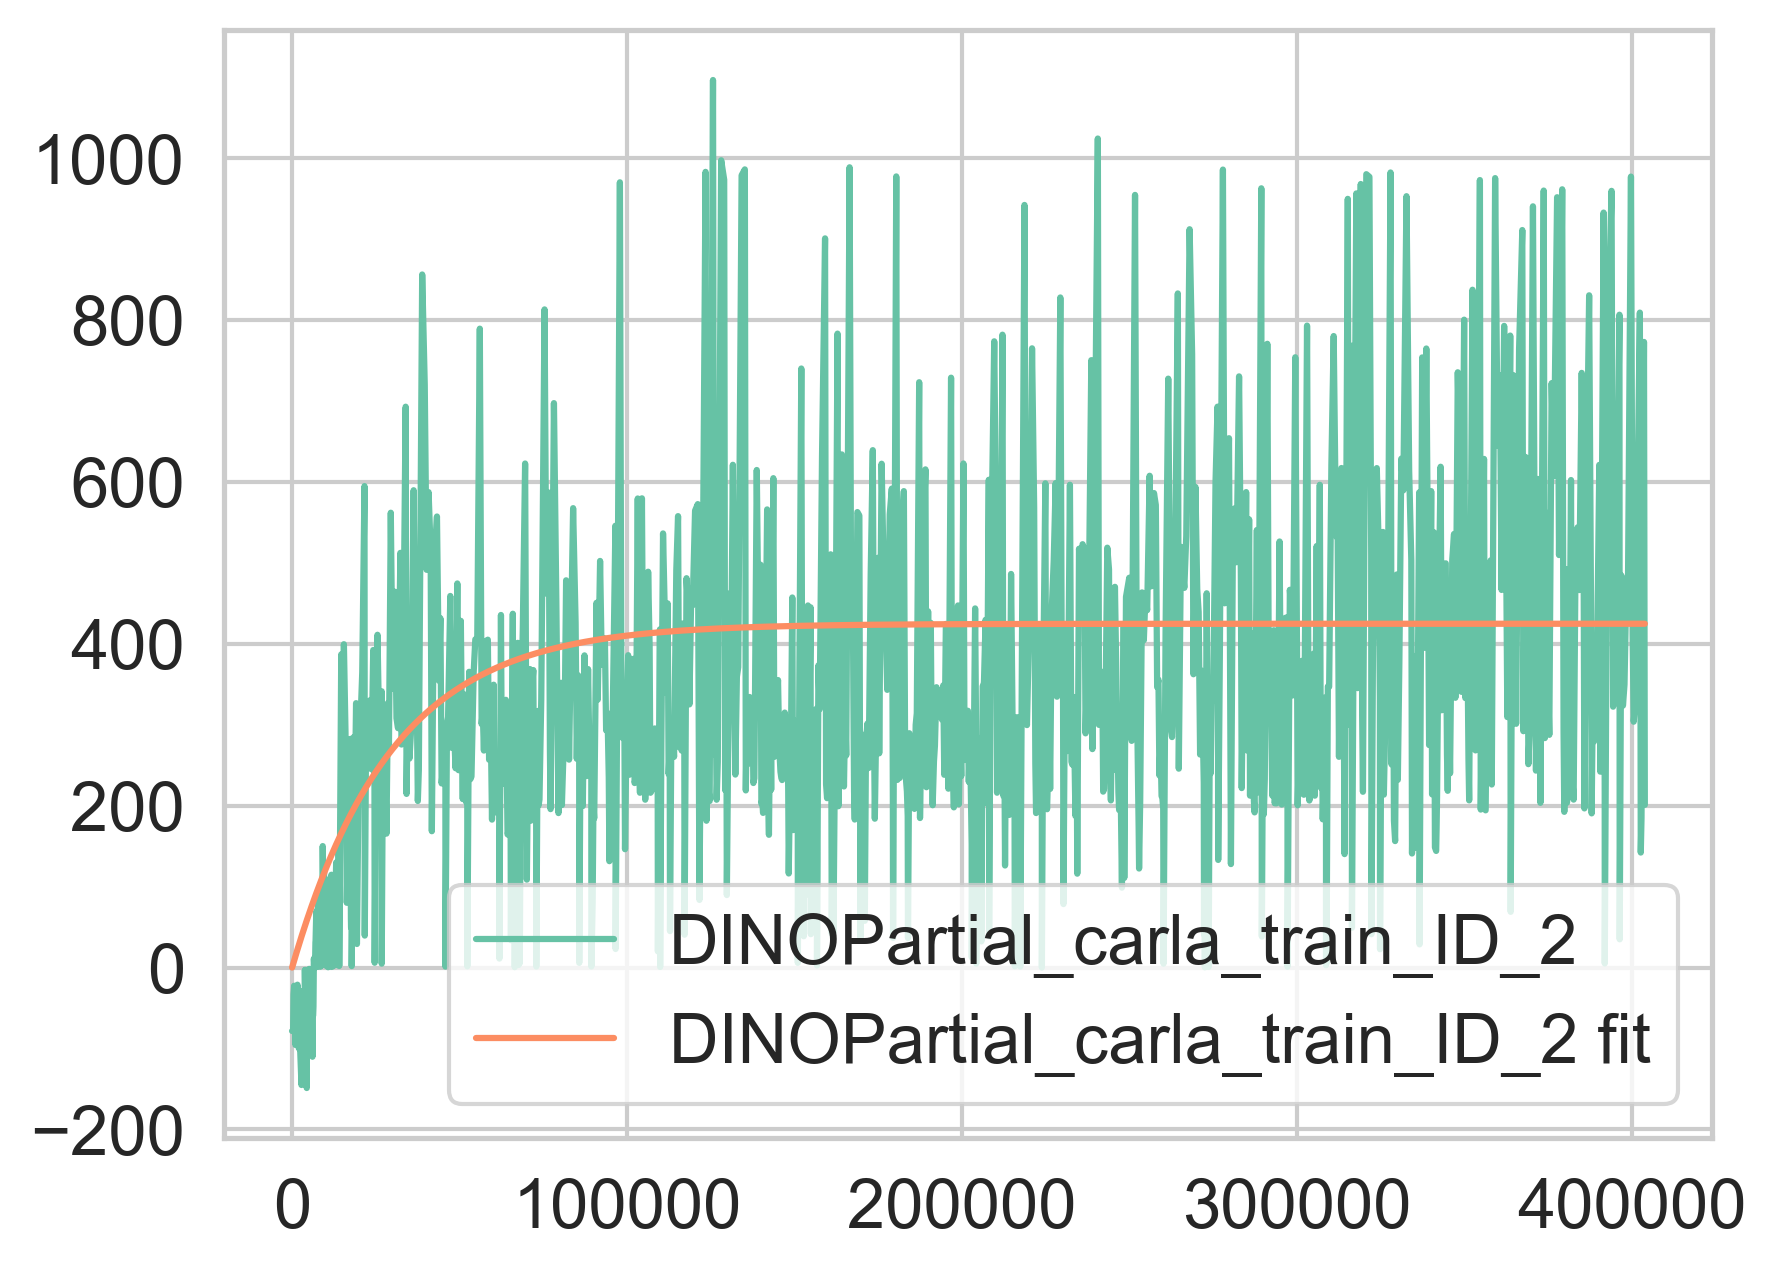

{'baseline_carla_train_ID': [2.420394333700286e-05,
  5.0593535093431487e-05,
  1.9137711229734514e-05],
 'CLIPFT_carla_train_ID': [3.322828773139859e-05,
  1.9577081707599988e-05,
  3.258312633706467e-05],
 'CLIPFreeze_carla_train_ID': [3.394420822068451e-05,
  3.565634561057414e-05,
  3.658755870976039e-05],
 'CLIPPartial_carla_train_ID': [3.15141710981962e-05,
  3.3697980618957895e-05,
  3.000329797958584e-05],
 'DINOFT_carla_train_ID': [2.4892920982111153e-05,
  2.1391500064376195e-05,
  1.909546937778646e-05],
 'DINOFreeze_carla_train_ID': [3.667628163505388e-05,
  5.0026157202695473e-05,
  5.115633184337359e-05],
 'DINOPartial_carla_train_ID': [2.243379447714194e-05,
  1.6530073810927977e-05,
  3.368320284149322e-05]}

<Figure size 1920x1440 with 0 Axes>

In [165]:
from scipy.optimize import curve_fit
res = {}
all_steps = []
step_interval = 10
window_size = 1
threshold = 0.6
for f in find_files_with_keyword('logdir/CARLA', 'scores.jsonl', 'train'):
    train_name = f.split('/')[3]

    found = False
    for k in res.keys():
        if k in train_name:
            found = True
            break
    
    windowed = smooth_interp(_read_log(f), step_interval, window_size)
    def exp_curve(n, a, k):
        return a * (1 - np.exp(-k * n))

    xs=np.arange(0, len(windowed)*10, step_interval)
    popt, pcov = curve_fit(exp_curve, xs, windowed, p0=[windowed.max(), 1e-3])
    a_est, k_est = popt
    if not found:
        res[train_name] = [k_est]
    else:
        res[k].append(k_est)

    plt.plot(xs, windowed, label=train_name)
    plt.plot(xs, exp_curve(xs, *popt), label=f"{train_name} fit")
    plt.legend()
    plt.show()
    plt.clf()

res

In [8]:
res = {}
all_steps = []
step_interval = 10
window_size = 2000
threshold = 0.9
for f in find_files_with_keyword('logdir/PICK_YCB', 'scores.jsonl', 'train'):
    train_name = f.split('/')[3]

    found = False
    for k in res.keys():
        if k in train_name:
            found = True
            break
    
    windowed = smooth_interp(_read_log(f), step_interval, window_size)
    normalised = (windowed - windowed.min()) / (windowed.max() - windowed.min() + 1e-8)


    first_index = np.argmax(normalised >= threshold)
    step = (first_index if first_index > 0 else len(normalised)) * step_interval
    if not found:
        res[train_name] = [step]
    else:
        res[k].append(step)

def bootstrap_ci(data, statfn=np.median, B=10000, alpha=0.05, seed=0):
    rng = np.random.default_rng(seed)
    boots = []
    n = len(data)
    for _ in range(B):
        sample = rng.choice(data, size=n, replace=True)
        boots.append(statfn(sample))
    lo = np.percentile(boots, 100*alpha/2)
    hi = np.percentile(boots, 100*(1-alpha/2))
    return statfn(data), lo, hi

for model, times in res.items():
    med, lo, hi = bootstrap_ci(np.array(times), statfn=np.median, B=5000)

    print(f"{model}: median={med:.0f}, 95% CI=[{lo:.0f},{hi:.0f}]")


baseline_pick_ycb_train_ID: median=729170, 95% CI=[602450,786740]
CLIPFT_pick_ycb_train_ID: median=749670, 95% CI=[693100,781780]
CLIPFreeze_pick_ycb_train_ID: median=558750, 95% CI=[419970,674560]
CLIPPartial_pick_ycb_train_ID: median=694120, 95% CI=[647440,779660]
DINOFT_pick_ycb_train_ID: median=600840, 95% CI=[503780,685590]
DINOFreeze_pick_ycb_train_ID: median=558550, 95% CI=[513880,626720]
DINOPartial_pick_ycb_train_ID: median=618420, 95% CI=[449740,630560]


In [97]:
from scipy.stats import kruskal
import scikit_posthocs as sp
stat, p = kruskal(*res.values())
print(f"H = {stat:.2f}, p = {p:.3f}")

def group_by_name(names=[]):
    grouped = {n: [] for n in names}

    for k, v in res.items():
        for group in grouped.keys():
            if group.lower() in k.lower():
                grouped[group].extend(v)

    return grouped

models_grp = group_by_name(['baseline', 'CLIP', 'DINO'])
ft_grp = group_by_name(['baseline', 'ft', 'partial', 'freeze'])

p_matrix = sp.posthoc_dunn([*res.values()], p_adjust=None)   # or 'bonferroni', 'fdr_bh', etc.
print(res)
print(p_matrix)
print()

p_matrix = sp.posthoc_dunn([*models_grp.values()], p_adjust=None)   # or 'bonferroni', 'fdr_bh', etc.
print(models_grp)
print(p_matrix)
print()

p_matrix = sp.posthoc_dunn([*ft_grp.values()], p_adjust=None)   # or 'bonferroni', 'fdr_bh', etc.
print(ft_grp)
print(p_matrix)

H = 14.04, p = 0.029
{'baseline_carla_train_ID': [90260, 71470, 183160], 'CLIPFT_carla_train_ID': [143950, 208830, -1], 'CLIPFreeze_carla_train_ID': [-1, -1, -1], 'CLIPPartial_carla_train_ID': [315560, 162750, 223600], 'DINOFT_carla_train_ID': [65680, 119980, 63230], 'DINOFreeze_carla_train_ID': [215070, 201190, 364470], 'DINOPartial_carla_train_ID': [63510, 166300, 36150]}
          1         2         3         4         5         6         7
1  1.000000  0.868925  0.080246  0.234764  0.552453  0.165684  0.597445
2  0.868925  1.000000  0.113140  0.175991  0.667877  0.120846  0.716564
3  0.080246  0.113140  1.000000  0.003309  0.248020  0.001716  0.222017
4  0.234764  0.175991  0.003309  1.000000  0.074706  0.843022  0.086115
5  0.552453  0.667877  0.248020  0.074706  1.000000  0.047670  0.947370
6  0.165684  0.120846  0.001716  0.843022  0.047670  1.000000  0.055584
7  0.597445  0.716564  0.222017  0.086115  0.947370  0.055584  1.000000

{'baseline': [90260, 71470, 183160], 'CLIP': [